In [85]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

In [36]:
patch_size = 56
batch_size = 128

In [47]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [48]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [49]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [50]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [51]:
latent_dim = 128

encoder_inputs = keras.Input(shape=(patch_size, patch_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_7[0][0]                   
____________________________________________________________________________________________

In [52]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 56, 56, 1)         289 

In [53]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [30]:
image_datagen = ImageDataGenerator()

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=50, batch_size=batch_size)


model_version = "0.0.0.1"
vae.save_weights(base_dir + '/vae_' + model_version + '.h5')


In [55]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)

In [58]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(patch_size, patch_size, 1),
    batch_size=batch_size,
    class_mode=None)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None)

Found 64598 images belonging to 1 classes.
Found 8075 images belonging to 1 classes.


In [61]:
for batch in train_generator:
    print(batch.shape)

ValueError: could not broadcast input array from shape (56,56,3) into shape (56,56,1,3)

In [68]:
image_datagen.flow(x_validation, batch_size=batch_size)

In [66]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# vae.fit(x_train, epochs=30, batch_size=128)
# vae.fit_generator(image_datagen.flow(x_train, x_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0], epochs=50)
# vae.fit(dataset, steps_per_epoch=x_train.shape[0], epochs=50, batch_size=batch_size)



vae.fit_generator(image_datagen.flow(x_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=image_datagen.flow(x_validation, batch_size=batch_size),
                validation_steps=x_validation.shape[0]#,
#                 callbacks=[checkpointer]
                )

# vae.fit_generator(
#         train_generator,
#         steps_per_epoch=x_train.shape[0],
#         epochs=50,
#         validation_data=validation_generator,
#         validation_steps=x_validation.shape[0]#,
# #         callbacks=[checkpointer]
#         )

model_version = "0.0.0.2"
vae.save_weights(base_dir + '/vae_' + model_version + '.h5')


NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.

In [70]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# vae.fit(x_train, epochs=30, batch_size=128)
# vae.fit_generator(image_datagen.flow(x_train, x_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0], epochs=50)
history_callback = vae.fit(x_train, epochs=65*batch_size, batch_size=batch_size)

model_version = "0.0.0.2"
vae.save_weights(base_dir + '/vae_' + model_version + '.h5')


Epoch 1/8320
505/505 [==============================] - 5s 11ms/step - loss: 415.8811 - reconstruction_loss: 414.3435 - kl_loss: 1.5376
Epoch 2/8320
505/505 [==============================] - ETA: 0s - loss: 415.3215 - reconstruction_loss: 413.7856 - kl_loss: 1.535 - 5s 11ms/step - loss: 415.3160 - reconstruction_loss: 413.7806 - kl_loss: 1.5353
Epoch 3/8320
505/505 [==============================] - 5s 11ms/step - loss: 415.3275 - reconstruction_loss: 413.7928 - kl_loss: 1.5347
Epoch 4/8320
505/505 [==============================] - 5s 11ms/step - loss: 415.3975 - reconstruction_loss: 413.8624 - kl_loss: 1.5351
Epoch 5/8320
505/505 [==============================] - 5s 11ms/step - loss: 415.2951 - reconstruction_loss: 413.7597 - kl_loss: 1.5353
Epoch 6/8320
505/505 [==============================] - 5s 11ms/step - loss: 415.3182 - reconstruction_loss: 413.7824 - kl_loss: 1.5358
Epoch 7/8320
505/505 [==============================] - 5s 11ms/step - loss: 415.3274 - reconstruction_loss:

505/505 [==============================] - 6s 11ms/step - loss: 414.4936 - reconstruction_loss: 412.9638 - kl_loss: 1.5298
Epoch 120/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.5079 - reconstruction_loss: 412.9788 - kl_loss: 1.5290
Epoch 121/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.4937 - reconstruction_loss: 412.9654 - kl_loss: 1.5283
Epoch 122/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.4885 - reconstruction_loss: 412.9589 - kl_loss: 1.5296
Epoch 123/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.4268 - reconstruction_loss: 412.8975 - kl_loss: 1.5293
Epoch 124/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.4606 - reconstruction_loss: 412.9317 - kl_loss: 1.5290
Epoch 125/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.4748 - reconstruction_loss: 412.9457 - kl_loss: 1.5290
Epoch 126/8320
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 414.2651 - reconstruction_loss: 412.7415 - kl_loss: 1.5236
Epoch 238/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.2729 - reconstruction_loss: 412.7498 - kl_loss: 1.5231
Epoch 239/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.2530 - reconstruction_loss: 412.7301 - kl_loss: 1.5228
Epoch 240/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.2689 - reconstruction_loss: 412.7469 - kl_loss: 1.5220
Epoch 241/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.2897 - reconstruction_loss: 412.7665 - kl_loss: 1.5232
Epoch 242/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.2879 - reconstruction_loss: 412.7648 - kl_loss: 1.5231
Epoch 243/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.2860 - reconstruction_loss: 412.7623 - kl_loss: 1.5236
Epoch 244/8320
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 414.1950 - reconstruction_loss: 412.6742 - kl_loss: 1.5208
Epoch 356/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.1478 - reconstruction_loss: 412.6278 - kl_loss: 1.5200
Epoch 357/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0967 - reconstruction_loss: 412.5766 - kl_loss: 1.5201
Epoch 358/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.1751 - reconstruction_loss: 412.6554 - kl_loss: 1.5197
Epoch 359/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.1150 - reconstruction_loss: 412.5948 - kl_loss: 1.5202
Epoch 360/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.1636 - reconstruction_loss: 412.6430 - kl_loss: 1.5206
Epoch 361/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.1713 - reconstruction_loss: 412.6507 - kl_loss: 1.5207
Epoch 362/8320
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 414.0605 - reconstruction_loss: 412.5409 - kl_loss: 1.5196
Epoch 474/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0920 - reconstruction_loss: 412.5721 - kl_loss: 1.5198
Epoch 475/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.1032 - reconstruction_loss: 412.5842 - kl_loss: 1.5190
Epoch 476/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.1088 - reconstruction_loss: 412.5901 - kl_loss: 1.5187
Epoch 477/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0915 - reconstruction_loss: 412.5722 - kl_loss: 1.5193
Epoch 478/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.1189 - reconstruction_loss: 412.6000 - kl_loss: 1.5189
Epoch 479/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.1352 - reconstruction_loss: 412.6155 - kl_loss: 1.5197
Epoch 480/8320
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 414.0912 - reconstruction_loss: 412.5718 - kl_loss: 1.5194
Epoch 592/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0561 - reconstruction_loss: 412.5353 - kl_loss: 1.5208
Epoch 593/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0255 - reconstruction_loss: 412.5056 - kl_loss: 1.5198
Epoch 594/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0613 - reconstruction_loss: 412.5417 - kl_loss: 1.5196
Epoch 595/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0382 - reconstruction_loss: 412.5187 - kl_loss: 1.5195
Epoch 596/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0151 - reconstruction_loss: 412.4954 - kl_loss: 1.5197
Epoch 597/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0943 - reconstruction_loss: 412.5735 - kl_loss: 1.5208
Epoch 598/8320
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 414.0099 - reconstruction_loss: 412.4872 - kl_loss: 1.5227
Epoch 710/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9735 - reconstruction_loss: 412.4506 - kl_loss: 1.5228
Epoch 711/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0035 - reconstruction_loss: 412.4812 - kl_loss: 1.5223
Epoch 712/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0414 - reconstruction_loss: 412.5176 - kl_loss: 1.5239
Epoch 713/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0031 - reconstruction_loss: 412.4805 - kl_loss: 1.5226
Epoch 714/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0295 - reconstruction_loss: 412.5071 - kl_loss: 1.5224
Epoch 715/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9682 - reconstruction_loss: 412.4452 - kl_loss: 1.5230
Epoch 716/8320
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 414.0321 - reconstruction_loss: 412.5095 - kl_loss: 1.5226
Epoch 828/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0018 - reconstruction_loss: 412.4790 - kl_loss: 1.5227
Epoch 829/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9820 - reconstruction_loss: 412.4595 - kl_loss: 1.5225
Epoch 830/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9788 - reconstruction_loss: 412.4555 - kl_loss: 1.5233
Epoch 831/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0145 - reconstruction_loss: 412.4906 - kl_loss: 1.5239
Epoch 832/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9768 - reconstruction_loss: 412.4535 - kl_loss: 1.5233
Epoch 833/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9874 - reconstruction_loss: 412.4634 - kl_loss: 1.5240
Epoch 834/8320
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.9504 - reconstruction_loss: 412.4268 - kl_loss: 1.5236
Epoch 946/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9861 - reconstruction_loss: 412.4626 - kl_loss: 1.5235
Epoch 947/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9863 - reconstruction_loss: 412.4625 - kl_loss: 1.5238
Epoch 948/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9973 - reconstruction_loss: 412.4734 - kl_loss: 1.5239
Epoch 949/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0067 - reconstruction_loss: 412.4831 - kl_loss: 1.5237
Epoch 950/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9861 - reconstruction_loss: 412.4618 - kl_loss: 1.5243
Epoch 951/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9958 - reconstruction_loss: 412.4718 - kl_loss: 1.5240
Epoch 952/8320
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.9464 - reconstruction_loss: 412.4228 - kl_loss: 1.5236
Epoch 1064/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8717 - reconstruction_loss: 412.3471 - kl_loss: 1.5246
Epoch 1065/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9429 - reconstruction_loss: 412.4188 - kl_loss: 1.5241
Epoch 1066/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9455 - reconstruction_loss: 412.4211 - kl_loss: 1.5243
Epoch 1067/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9361 - reconstruction_loss: 412.4114 - kl_loss: 1.5247
Epoch 1068/8320
505/505 [==============================] - 6s 11ms/step - loss: 414.0098 - reconstruction_loss: 412.4858 - kl_loss: 1.5239
Epoch 1069/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9185 - reconstruction_loss: 412.3937 - kl_loss: 1.5248
Epoch 1070/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9529 - reconstruction_loss: 412.4281 - kl_loss: 1.5247
Epoch 1123/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9442 - reconstruction_loss: 412.4204 - kl_loss: 1.5237
Epoch 1124/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9464 - reconstruction_loss: 412.4219 - kl_loss: 1.5244
Epoch 1125/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9306 - reconstruction_loss: 412.4060 - kl_loss: 1.5246
Epoch 1126/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9185 - reconstruction_loss: 412.3945 - kl_loss: 1.5240
Epoch 1127/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9789 - reconstruction_loss: 412.4545 - kl_loss: 1.5243
Epoch 1128/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9067 - reconstruction_loss: 412.3825 - kl_loss: 1.5243
Epoch 1129/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9908 - reconstruction_loss: 412.4658 - kl_loss: 1.5249
Epoch 1182/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9531 - reconstruction_loss: 412.4281 - kl_loss: 1.5249
Epoch 1183/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9683 - reconstruction_loss: 412.4428 - kl_loss: 1.5256
Epoch 1184/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9464 - reconstruction_loss: 412.4214 - kl_loss: 1.5249
Epoch 1185/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9253 - reconstruction_loss: 412.4004 - kl_loss: 1.5249
Epoch 1186/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9451 - reconstruction_loss: 412.4196 - kl_loss: 1.5255
Epoch 1187/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8918 - reconstruction_loss: 412.3674 - kl_loss: 1.5244
Epoch 1188/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9155 - reconstruction_loss: 412.3901 - kl_loss: 1.5255
Epoch 1241/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9026 - reconstruction_loss: 412.3777 - kl_loss: 1.5249
Epoch 1242/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9577 - reconstruction_loss: 412.4319 - kl_loss: 1.5258
Epoch 1243/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9341 - reconstruction_loss: 412.4082 - kl_loss: 1.5259
Epoch 1244/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9014 - reconstruction_loss: 412.3761 - kl_loss: 1.5253
Epoch 1245/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9069 - reconstruction_loss: 412.3820 - kl_loss: 1.5249
Epoch 1246/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9636 - reconstruction_loss: 412.4376 - kl_loss: 1.5260
Epoch 1247/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8835 - reconstruction_loss: 412.3586 - kl_loss: 1.5250
Epoch 1300/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8476 - reconstruction_loss: 412.3221 - kl_loss: 1.5254
Epoch 1301/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9226 - reconstruction_loss: 412.3968 - kl_loss: 1.5258
Epoch 1302/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8890 - reconstruction_loss: 412.3632 - kl_loss: 1.5258
Epoch 1303/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9248 - reconstruction_loss: 412.3989 - kl_loss: 1.5259
Epoch 1304/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9235 - reconstruction_loss: 412.3981 - kl_loss: 1.5254
Epoch 1305/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9110 - reconstruction_loss: 412.3849 - kl_loss: 1.5261
Epoch 1306/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9252 - reconstruction_loss: 412.4001 - kl_loss: 1.5251
Epoch 1359/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8934 - reconstruction_loss: 412.3675 - kl_loss: 1.5258
Epoch 1360/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9148 - reconstruction_loss: 412.3899 - kl_loss: 1.5248
Epoch 1361/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8568 - reconstruction_loss: 412.3315 - kl_loss: 1.5253
Epoch 1362/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8399 - reconstruction_loss: 412.3144 - kl_loss: 1.5254
Epoch 1363/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9044 - reconstruction_loss: 412.3783 - kl_loss: 1.5261
Epoch 1364/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9472 - reconstruction_loss: 412.4220 - kl_loss: 1.5252
Epoch 1365/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9390 - reconstruction_loss: 412.4127 - kl_loss: 1.5263
Epoch 1418/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9335 - reconstruction_loss: 412.4082 - kl_loss: 1.5253
Epoch 1419/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9209 - reconstruction_loss: 412.3943 - kl_loss: 1.5266
Epoch 1420/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8645 - reconstruction_loss: 412.3382 - kl_loss: 1.5263
Epoch 1421/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8267 - reconstruction_loss: 412.2991 - kl_loss: 1.5276
Epoch 1422/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9147 - reconstruction_loss: 412.3888 - kl_loss: 1.5259
Epoch 1423/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8949 - reconstruction_loss: 412.3686 - kl_loss: 1.5263
Epoch 1424/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9296 - reconstruction_loss: 412.4032 - kl_loss: 1.5264
Epoch 1477/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8952 - reconstruction_loss: 412.3688 - kl_loss: 1.5265
Epoch 1478/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8925 - reconstruction_loss: 412.3668 - kl_loss: 1.5257
Epoch 1479/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8939 - reconstruction_loss: 412.3689 - kl_loss: 1.5250
Epoch 1480/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8569 - reconstruction_loss: 412.3308 - kl_loss: 1.5261
Epoch 1481/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8556 - reconstruction_loss: 412.3298 - kl_loss: 1.5259
Epoch 1482/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8410 - reconstruction_loss: 412.3149 - kl_loss: 1.5261
Epoch 1483/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9048 - reconstruction_loss: 412.3773 - kl_loss: 1.5275
Epoch 1536/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8743 - reconstruction_loss: 412.3487 - kl_loss: 1.5256
Epoch 1537/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8707 - reconstruction_loss: 412.3441 - kl_loss: 1.5267
Epoch 1538/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9105 - reconstruction_loss: 412.3852 - kl_loss: 1.5253
Epoch 1539/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8754 - reconstruction_loss: 412.3493 - kl_loss: 1.5261
Epoch 1540/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8637 - reconstruction_loss: 412.3379 - kl_loss: 1.5258
Epoch 1541/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8891 - reconstruction_loss: 412.3622 - kl_loss: 1.5269
Epoch 1542/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9267 - reconstruction_loss: 412.4001 - kl_loss: 1.5266
Epoch 1595/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9347 - reconstruction_loss: 412.4086 - kl_loss: 1.5261
Epoch 1596/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9115 - reconstruction_loss: 412.3866 - kl_loss: 1.5249
Epoch 1597/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8589 - reconstruction_loss: 412.3331 - kl_loss: 1.5258
Epoch 1598/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8598 - reconstruction_loss: 412.3326 - kl_loss: 1.5272
Epoch 1599/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8763 - reconstruction_loss: 412.3492 - kl_loss: 1.5271
Epoch 1600/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9741 - reconstruction_loss: 412.4488 - kl_loss: 1.5253
Epoch 1601/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9123 - reconstruction_loss: 412.3862 - kl_loss: 1.5260
Epoch 1654/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9078 - reconstruction_loss: 412.3814 - kl_loss: 1.5264
Epoch 1655/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8811 - reconstruction_loss: 412.3550 - kl_loss: 1.5261
Epoch 1656/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8537 - reconstruction_loss: 412.3277 - kl_loss: 1.5260
Epoch 1657/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9213 - reconstruction_loss: 412.3947 - kl_loss: 1.5266
Epoch 1658/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8544 - reconstruction_loss: 412.3285 - kl_loss: 1.5258
Epoch 1659/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8624 - reconstruction_loss: 412.3362 - kl_loss: 1.5262
Epoch 1660/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8808 - reconstruction_loss: 412.3545 - kl_loss: 1.5262
Epoch 1713/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8944 - reconstruction_loss: 412.3688 - kl_loss: 1.5256
Epoch 1714/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8829 - reconstruction_loss: 412.3562 - kl_loss: 1.5267
Epoch 1715/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8624 - reconstruction_loss: 412.3361 - kl_loss: 1.5263
Epoch 1716/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8756 - reconstruction_loss: 412.3493 - kl_loss: 1.5264
Epoch 1717/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8955 - reconstruction_loss: 412.3700 - kl_loss: 1.5255
Epoch 1718/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8525 - reconstruction_loss: 412.3260 - kl_loss: 1.5265
Epoch 1719/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8994 - reconstruction_loss: 412.3727 - kl_loss: 1.5268
Epoch 1772/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8532 - reconstruction_loss: 412.3272 - kl_loss: 1.5260
Epoch 1773/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8354 - reconstruction_loss: 412.3102 - kl_loss: 1.5252
Epoch 1774/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8648 - reconstruction_loss: 412.3386 - kl_loss: 1.5262
Epoch 1775/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8621 - reconstruction_loss: 412.3370 - kl_loss: 1.5251
Epoch 1776/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8390 - reconstruction_loss: 412.3127 - kl_loss: 1.5263
Epoch 1777/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9142 - reconstruction_loss: 412.3879 - kl_loss: 1.5263
Epoch 1778/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9030 - reconstruction_loss: 412.3757 - kl_loss: 1.5273
Epoch 1831/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8296 - reconstruction_loss: 412.3037 - kl_loss: 1.5260
Epoch 1832/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8584 - reconstruction_loss: 412.3319 - kl_loss: 1.5265
Epoch 1833/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8870 - reconstruction_loss: 412.3615 - kl_loss: 1.5255
Epoch 1834/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8215 - reconstruction_loss: 412.2948 - kl_loss: 1.5267
Epoch 1835/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9014 - reconstruction_loss: 412.3755 - kl_loss: 1.5259
Epoch 1836/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8456 - reconstruction_loss: 412.3194 - kl_loss: 1.5263
Epoch 1837/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8836 - reconstruction_loss: 412.3574 - kl_loss: 1.5261
Epoch 1890/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8345 - reconstruction_loss: 412.3084 - kl_loss: 1.5261
Epoch 1891/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8851 - reconstruction_loss: 412.3591 - kl_loss: 1.5259
Epoch 1892/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8873 - reconstruction_loss: 412.3611 - kl_loss: 1.5261
Epoch 1893/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8931 - reconstruction_loss: 412.3674 - kl_loss: 1.5257
Epoch 1894/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8737 - reconstruction_loss: 412.3472 - kl_loss: 1.5265
Epoch 1895/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8858 - reconstruction_loss: 412.3591 - kl_loss: 1.5267
Epoch 1896/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8651 - reconstruction_loss: 412.3392 - kl_loss: 1.5259
Epoch 1949/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8292 - reconstruction_loss: 412.3031 - kl_loss: 1.5261
Epoch 1950/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8037 - reconstruction_loss: 412.2775 - kl_loss: 1.5263
Epoch 1951/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8874 - reconstruction_loss: 412.3616 - kl_loss: 1.5258
Epoch 1952/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8585 - reconstruction_loss: 412.3322 - kl_loss: 1.5263
Epoch 1953/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7831 - reconstruction_loss: 412.2564 - kl_loss: 1.5267
Epoch 1954/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8304 - reconstruction_loss: 412.3041 - kl_loss: 1.5264
Epoch 1955/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.9021 - reconstruction_loss: 412.3761 - kl_loss: 1.5259
Epoch 2008/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8658 - reconstruction_loss: 412.3385 - kl_loss: 1.5273
Epoch 2009/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8854 - reconstruction_loss: 412.3593 - kl_loss: 1.5261
Epoch 2010/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8806 - reconstruction_loss: 412.3539 - kl_loss: 1.5267
Epoch 2011/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8984 - reconstruction_loss: 412.3711 - kl_loss: 1.5272
Epoch 2012/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8751 - reconstruction_loss: 412.3489 - kl_loss: 1.5262
Epoch 2013/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8389 - reconstruction_loss: 412.3128 - kl_loss: 1.5261
Epoch 2014/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8312 - reconstruction_loss: 412.3048 - kl_loss: 1.5264
Epoch 2067/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8374 - reconstruction_loss: 412.3116 - kl_loss: 1.5258
Epoch 2068/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8695 - reconstruction_loss: 412.3436 - kl_loss: 1.5259
Epoch 2069/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8655 - reconstruction_loss: 412.3381 - kl_loss: 1.5275
Epoch 2070/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8569 - reconstruction_loss: 412.3301 - kl_loss: 1.5269
Epoch 2071/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8700 - reconstruction_loss: 412.3438 - kl_loss: 1.5262
Epoch 2072/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8912 - reconstruction_loss: 412.3639 - kl_loss: 1.5273
Epoch 2073/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8424 - reconstruction_loss: 412.3160 - kl_loss: 1.5265
Epoch 2126/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8653 - reconstruction_loss: 412.3394 - kl_loss: 1.5259
Epoch 2127/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9127 - reconstruction_loss: 412.3870 - kl_loss: 1.5258
Epoch 2128/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8656 - reconstruction_loss: 412.3398 - kl_loss: 1.5258
Epoch 2129/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8858 - reconstruction_loss: 412.3603 - kl_loss: 1.5255
Epoch 2130/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8447 - reconstruction_loss: 412.3181 - kl_loss: 1.5266
Epoch 2131/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8698 - reconstruction_loss: 412.3430 - kl_loss: 1.5267
Epoch 2132/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8621 - reconstruction_loss: 412.3353 - kl_loss: 1.5268
Epoch 2185/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8140 - reconstruction_loss: 412.2878 - kl_loss: 1.5262
Epoch 2186/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8258 - reconstruction_loss: 412.2990 - kl_loss: 1.5268
Epoch 2187/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8156 - reconstruction_loss: 412.2890 - kl_loss: 1.5267
Epoch 2188/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8384 - reconstruction_loss: 412.3108 - kl_loss: 1.5276
Epoch 2189/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8741 - reconstruction_loss: 412.3479 - kl_loss: 1.5262
Epoch 2190/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8603 - reconstruction_loss: 412.3338 - kl_loss: 1.5266
Epoch 2191/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8924 - reconstruction_loss: 412.3656 - kl_loss: 1.5267
Epoch 2244/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8158 - reconstruction_loss: 412.2897 - kl_loss: 1.5261
Epoch 2245/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7818 - reconstruction_loss: 412.2552 - kl_loss: 1.5266
Epoch 2246/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8780 - reconstruction_loss: 412.3515 - kl_loss: 1.5266
Epoch 2247/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8630 - reconstruction_loss: 412.3367 - kl_loss: 1.5263
Epoch 2248/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8172 - reconstruction_loss: 412.2904 - kl_loss: 1.5268
Epoch 2249/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8567 - reconstruction_loss: 412.3313 - kl_loss: 1.5254
Epoch 2250/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8325 - reconstruction_loss: 412.3064 - kl_loss: 1.5261
Epoch 2303/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8274 - reconstruction_loss: 412.3006 - kl_loss: 1.5268
Epoch 2304/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8574 - reconstruction_loss: 412.3314 - kl_loss: 1.5260
Epoch 2305/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8407 - reconstruction_loss: 412.3140 - kl_loss: 1.5266
Epoch 2306/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.9246 - reconstruction_loss: 412.3973 - kl_loss: 1.5272
Epoch 2307/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8108 - reconstruction_loss: 412.2848 - kl_loss: 1.5260
Epoch 2308/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8091 - reconstruction_loss: 412.2823 - kl_loss: 1.5267
Epoch 2309/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8302 - reconstruction_loss: 412.3041 - kl_loss: 1.5261
Epoch 2362/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7969 - reconstruction_loss: 412.2707 - kl_loss: 1.5261
Epoch 2363/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8822 - reconstruction_loss: 412.3564 - kl_loss: 1.5258
Epoch 2364/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7786 - reconstruction_loss: 412.2516 - kl_loss: 1.5270
Epoch 2365/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8870 - reconstruction_loss: 412.3604 - kl_loss: 1.5266
Epoch 2366/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8623 - reconstruction_loss: 412.3356 - kl_loss: 1.5267
Epoch 2367/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8001 - reconstruction_loss: 412.2734 - kl_loss: 1.5267
Epoch 2368/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8317 - reconstruction_loss: 412.3060 - kl_loss: 1.5257
Epoch 2421/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8244 - reconstruction_loss: 412.2984 - kl_loss: 1.5260
Epoch 2422/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8661 - reconstruction_loss: 412.3393 - kl_loss: 1.5268
Epoch 2423/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7865 - reconstruction_loss: 412.2594 - kl_loss: 1.5271
Epoch 2424/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8466 - reconstruction_loss: 412.3198 - kl_loss: 1.5268
Epoch 2425/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7874 - reconstruction_loss: 412.2613 - kl_loss: 1.5261
Epoch 2426/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7704 - reconstruction_loss: 412.2438 - kl_loss: 1.5266
Epoch 2427/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8610 - reconstruction_loss: 412.3359 - kl_loss: 1.5251
Epoch 2480/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8551 - reconstruction_loss: 412.3290 - kl_loss: 1.5261
Epoch 2481/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8298 - reconstruction_loss: 412.3029 - kl_loss: 1.5269
Epoch 2482/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8608 - reconstruction_loss: 412.3344 - kl_loss: 1.5265
Epoch 2483/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8651 - reconstruction_loss: 412.3393 - kl_loss: 1.5257
Epoch 2484/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8469 - reconstruction_loss: 412.3208 - kl_loss: 1.5261
Epoch 2485/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8594 - reconstruction_loss: 412.3332 - kl_loss: 1.5261
Epoch 2486/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8258 - reconstruction_loss: 412.2989 - kl_loss: 1.5269
Epoch 2539/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8155 - reconstruction_loss: 412.2888 - kl_loss: 1.5266
Epoch 2540/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8794 - reconstruction_loss: 412.3530 - kl_loss: 1.5264
Epoch 2541/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8734 - reconstruction_loss: 412.3463 - kl_loss: 1.5270
Epoch 2542/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7966 - reconstruction_loss: 412.2689 - kl_loss: 1.5277
Epoch 2543/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8334 - reconstruction_loss: 412.3070 - kl_loss: 1.5264
Epoch 2544/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7617 - reconstruction_loss: 412.2351 - kl_loss: 1.5266
Epoch 2545/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8371 - reconstruction_loss: 412.3110 - kl_loss: 1.5261
Epoch 2598/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7555 - reconstruction_loss: 412.2291 - kl_loss: 1.5263
Epoch 2599/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8296 - reconstruction_loss: 412.3038 - kl_loss: 1.5258
Epoch 2600/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8127 - reconstruction_loss: 412.2856 - kl_loss: 1.5270
Epoch 2601/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8631 - reconstruction_loss: 412.3371 - kl_loss: 1.5260
Epoch 2602/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8075 - reconstruction_loss: 412.2816 - kl_loss: 1.5259
Epoch 2603/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8311 - reconstruction_loss: 412.3038 - kl_loss: 1.5273
Epoch 2604/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7961 - reconstruction_loss: 412.2703 - kl_loss: 1.5258
Epoch 2657/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8631 - reconstruction_loss: 412.3374 - kl_loss: 1.5257
Epoch 2658/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8469 - reconstruction_loss: 412.3199 - kl_loss: 1.5269
Epoch 2659/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8016 - reconstruction_loss: 412.2755 - kl_loss: 1.5261
Epoch 2660/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8225 - reconstruction_loss: 412.2969 - kl_loss: 1.5256
Epoch 2661/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8285 - reconstruction_loss: 412.3019 - kl_loss: 1.5266
Epoch 2662/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8255 - reconstruction_loss: 412.2991 - kl_loss: 1.5265
Epoch 2663/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8072 - reconstruction_loss: 412.2811 - kl_loss: 1.5261
Epoch 2716/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8522 - reconstruction_loss: 412.3255 - kl_loss: 1.5267
Epoch 2717/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8468 - reconstruction_loss: 412.3205 - kl_loss: 1.5263
Epoch 2718/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8105 - reconstruction_loss: 412.2838 - kl_loss: 1.5267
Epoch 2719/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8643 - reconstruction_loss: 412.3383 - kl_loss: 1.5261
Epoch 2720/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8176 - reconstruction_loss: 412.2897 - kl_loss: 1.5279
Epoch 2721/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8116 - reconstruction_loss: 412.2854 - kl_loss: 1.5262
Epoch 2722/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8162 - reconstruction_loss: 412.2901 - kl_loss: 1.5262
Epoch 2775/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8273 - reconstruction_loss: 412.3014 - kl_loss: 1.5260
Epoch 2776/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8287 - reconstruction_loss: 412.3020 - kl_loss: 1.5266
Epoch 2777/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8341 - reconstruction_loss: 412.3080 - kl_loss: 1.5261
Epoch 2778/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7904 - reconstruction_loss: 412.2648 - kl_loss: 1.5255
Epoch 2779/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8622 - reconstruction_loss: 412.3365 - kl_loss: 1.5256
Epoch 2780/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8030 - reconstruction_loss: 412.2764 - kl_loss: 1.5266
Epoch 2781/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8350 - reconstruction_loss: 412.3086 - kl_loss: 1.5263
Epoch 2834/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8334 - reconstruction_loss: 412.3063 - kl_loss: 1.5271
Epoch 2835/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8372 - reconstruction_loss: 412.3110 - kl_loss: 1.5263
Epoch 2836/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8281 - reconstruction_loss: 412.3015 - kl_loss: 1.5267
Epoch 2837/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8306 - reconstruction_loss: 412.3047 - kl_loss: 1.5259
Epoch 2838/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8496 - reconstruction_loss: 412.3235 - kl_loss: 1.5260
Epoch 2839/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8648 - reconstruction_loss: 412.3388 - kl_loss: 1.5260
Epoch 2840/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8166 - reconstruction_loss: 412.2907 - kl_loss: 1.5260
Epoch 2893/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8170 - reconstruction_loss: 412.2899 - kl_loss: 1.5271
Epoch 2894/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8324 - reconstruction_loss: 412.3065 - kl_loss: 1.5259
Epoch 2895/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8468 - reconstruction_loss: 412.3203 - kl_loss: 1.5265
Epoch 2896/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8476 - reconstruction_loss: 412.3211 - kl_loss: 1.5265
Epoch 2897/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7990 - reconstruction_loss: 412.2721 - kl_loss: 1.5269
Epoch 2898/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7666 - reconstruction_loss: 412.2403 - kl_loss: 1.5263
Epoch 2899/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8312 - reconstruction_loss: 412.3036 - kl_loss: 1.5276
Epoch 2952/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7778 - reconstruction_loss: 412.2518 - kl_loss: 1.5260
Epoch 2953/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8110 - reconstruction_loss: 412.2845 - kl_loss: 1.5265
Epoch 2954/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8293 - reconstruction_loss: 412.3035 - kl_loss: 1.5258
Epoch 2955/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8286 - reconstruction_loss: 412.3020 - kl_loss: 1.5265
Epoch 2956/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8194 - reconstruction_loss: 412.2934 - kl_loss: 1.5260
Epoch 2957/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8109 - reconstruction_loss: 412.2846 - kl_loss: 1.5263
Epoch 2958/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7639 - reconstruction_loss: 412.2374 - kl_loss: 1.5265
Epoch 3011/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8324 - reconstruction_loss: 412.3058 - kl_loss: 1.5266
Epoch 3012/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8236 - reconstruction_loss: 412.2965 - kl_loss: 1.5271
Epoch 3013/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8092 - reconstruction_loss: 412.2823 - kl_loss: 1.5269
Epoch 3014/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8638 - reconstruction_loss: 412.3377 - kl_loss: 1.5261
Epoch 3015/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8389 - reconstruction_loss: 412.3121 - kl_loss: 1.5268
Epoch 3016/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8416 - reconstruction_loss: 412.3148 - kl_loss: 1.5268
Epoch 3017/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8451 - reconstruction_loss: 412.3185 - kl_loss: 1.5266
Epoch 3070/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8232 - reconstruction_loss: 412.2967 - kl_loss: 1.5265
Epoch 3071/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8119 - reconstruction_loss: 412.2857 - kl_loss: 1.5262
Epoch 3072/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8219 - reconstruction_loss: 412.2961 - kl_loss: 1.5258
Epoch 3073/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8215 - reconstruction_loss: 412.2958 - kl_loss: 1.5257
Epoch 3074/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7755 - reconstruction_loss: 412.2490 - kl_loss: 1.5265
Epoch 3075/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7951 - reconstruction_loss: 412.2685 - kl_loss: 1.5265
Epoch 3076/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7763 - reconstruction_loss: 412.2485 - kl_loss: 1.5278
Epoch 3129/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8316 - reconstruction_loss: 412.3052 - kl_loss: 1.5263
Epoch 3130/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8077 - reconstruction_loss: 412.2819 - kl_loss: 1.5258
Epoch 3131/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8274 - reconstruction_loss: 412.3007 - kl_loss: 1.5267
Epoch 3132/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8603 - reconstruction_loss: 412.3352 - kl_loss: 1.5251
Epoch 3133/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8233 - reconstruction_loss: 412.2972 - kl_loss: 1.5261
Epoch 3134/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7777 - reconstruction_loss: 412.2504 - kl_loss: 1.5273
Epoch 3135/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7368 - reconstruction_loss: 412.2103 - kl_loss: 1.5265
Epoch 3188/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8780 - reconstruction_loss: 412.3507 - kl_loss: 1.5273
Epoch 3189/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8113 - reconstruction_loss: 412.2855 - kl_loss: 1.5258
Epoch 3190/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8540 - reconstruction_loss: 412.3268 - kl_loss: 1.5272
Epoch 3191/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8163 - reconstruction_loss: 412.2897 - kl_loss: 1.5266
Epoch 3192/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8300 - reconstruction_loss: 412.3042 - kl_loss: 1.5257
Epoch 3193/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8331 - reconstruction_loss: 412.3071 - kl_loss: 1.5260
Epoch 3194/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8343 - reconstruction_loss: 412.3083 - kl_loss: 1.5260
Epoch 3247/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8040 - reconstruction_loss: 412.2781 - kl_loss: 1.5259
Epoch 3248/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8468 - reconstruction_loss: 412.3196 - kl_loss: 1.5273
Epoch 3249/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8191 - reconstruction_loss: 412.2930 - kl_loss: 1.5261
Epoch 3250/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8090 - reconstruction_loss: 412.2822 - kl_loss: 1.5268
Epoch 3251/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8527 - reconstruction_loss: 412.3269 - kl_loss: 1.5258
Epoch 3252/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8276 - reconstruction_loss: 412.3005 - kl_loss: 1.5271
Epoch 3253/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8437 - reconstruction_loss: 412.3175 - kl_loss: 1.5262
Epoch 3306/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8072 - reconstruction_loss: 412.2800 - kl_loss: 1.5272
Epoch 3307/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8533 - reconstruction_loss: 412.3271 - kl_loss: 1.5263
Epoch 3308/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8321 - reconstruction_loss: 412.3058 - kl_loss: 1.5263
Epoch 3309/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8087 - reconstruction_loss: 412.2826 - kl_loss: 1.5260
Epoch 3310/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8196 - reconstruction_loss: 412.2940 - kl_loss: 1.5256
Epoch 3311/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8143 - reconstruction_loss: 412.2875 - kl_loss: 1.5268
Epoch 3312/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8835 - reconstruction_loss: 412.3569 - kl_loss: 1.5266
Epoch 3365/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8313 - reconstruction_loss: 412.3049 - kl_loss: 1.5264
Epoch 3366/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8392 - reconstruction_loss: 412.3126 - kl_loss: 1.5266
Epoch 3367/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7662 - reconstruction_loss: 412.2385 - kl_loss: 1.5277
Epoch 3368/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8850 - reconstruction_loss: 412.3590 - kl_loss: 1.5260
Epoch 3369/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8112 - reconstruction_loss: 412.2841 - kl_loss: 1.5271
Epoch 3370/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7971 - reconstruction_loss: 412.2701 - kl_loss: 1.5270
Epoch 3371/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7753 - reconstruction_loss: 412.2479 - kl_loss: 1.5274
Epoch 3424/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8280 - reconstruction_loss: 412.3014 - kl_loss: 1.5265
Epoch 3425/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7555 - reconstruction_loss: 412.2289 - kl_loss: 1.5266
Epoch 3426/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7795 - reconstruction_loss: 412.2530 - kl_loss: 1.5265
Epoch 3427/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7931 - reconstruction_loss: 412.2672 - kl_loss: 1.5259
Epoch 3428/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8342 - reconstruction_loss: 412.3067 - kl_loss: 1.5275
Epoch 3429/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8194 - reconstruction_loss: 412.2921 - kl_loss: 1.5272
Epoch 3430/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7585 - reconstruction_loss: 412.2318 - kl_loss: 1.5266
Epoch 3483/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8173 - reconstruction_loss: 412.2908 - kl_loss: 1.5266
Epoch 3484/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8665 - reconstruction_loss: 412.3393 - kl_loss: 1.5271
Epoch 3485/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7925 - reconstruction_loss: 412.2665 - kl_loss: 1.5260
Epoch 3486/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8744 - reconstruction_loss: 412.3480 - kl_loss: 1.5264
Epoch 3487/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7689 - reconstruction_loss: 412.2416 - kl_loss: 1.5273
Epoch 3488/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8153 - reconstruction_loss: 412.2886 - kl_loss: 1.5267
Epoch 3489/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7561 - reconstruction_loss: 412.2286 - kl_loss: 1.5274
Epoch 3542/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8247 - reconstruction_loss: 412.2986 - kl_loss: 1.5261
Epoch 3543/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8318 - reconstruction_loss: 412.3048 - kl_loss: 1.5271
Epoch 3544/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8175 - reconstruction_loss: 412.2903 - kl_loss: 1.5272
Epoch 3545/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7708 - reconstruction_loss: 412.2446 - kl_loss: 1.5262
Epoch 3546/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8126 - reconstruction_loss: 412.2861 - kl_loss: 1.5265
Epoch 3547/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7571 - reconstruction_loss: 412.2300 - kl_loss: 1.5271
Epoch 3548/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8058 - reconstruction_loss: 412.2781 - kl_loss: 1.5276
Epoch 3601/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8133 - reconstruction_loss: 412.2858 - kl_loss: 1.5275
Epoch 3602/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8477 - reconstruction_loss: 412.3204 - kl_loss: 1.5272
Epoch 3603/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8327 - reconstruction_loss: 412.3058 - kl_loss: 1.5269
Epoch 3604/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7487 - reconstruction_loss: 412.2206 - kl_loss: 1.5281
Epoch 3605/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7875 - reconstruction_loss: 412.2598 - kl_loss: 1.5277
Epoch 3606/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8226 - reconstruction_loss: 412.2957 - kl_loss: 1.5269
Epoch 3607/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7930 - reconstruction_loss: 412.2653 - kl_loss: 1.5277
Epoch 3660/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8392 - reconstruction_loss: 412.3130 - kl_loss: 1.5263
Epoch 3661/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7394 - reconstruction_loss: 412.2127 - kl_loss: 1.5267
Epoch 3662/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8220 - reconstruction_loss: 412.2953 - kl_loss: 1.5267
Epoch 3663/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7895 - reconstruction_loss: 412.2618 - kl_loss: 1.5277
Epoch 3664/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7514 - reconstruction_loss: 412.2245 - kl_loss: 1.5269
Epoch 3665/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8471 - reconstruction_loss: 412.3210 - kl_loss: 1.5261
Epoch 3666/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7633 - reconstruction_loss: 412.2363 - kl_loss: 1.5270
Epoch 3719/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8120 - reconstruction_loss: 412.2849 - kl_loss: 1.5271
Epoch 3720/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8338 - reconstruction_loss: 412.3067 - kl_loss: 1.5271
Epoch 3721/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7841 - reconstruction_loss: 412.2567 - kl_loss: 1.5274
Epoch 3722/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8149 - reconstruction_loss: 412.2886 - kl_loss: 1.5263
Epoch 3723/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8180 - reconstruction_loss: 412.2901 - kl_loss: 1.5278
Epoch 3724/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7541 - reconstruction_loss: 412.2272 - kl_loss: 1.5269
Epoch 3725/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8308 - reconstruction_loss: 412.3038 - kl_loss: 1.5271
Epoch 3778/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7945 - reconstruction_loss: 412.2661 - kl_loss: 1.5285
Epoch 3779/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7706 - reconstruction_loss: 412.2440 - kl_loss: 1.5267
Epoch 3780/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8344 - reconstruction_loss: 412.3077 - kl_loss: 1.5267
Epoch 3781/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8069 - reconstruction_loss: 412.2798 - kl_loss: 1.5271
Epoch 3782/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7984 - reconstruction_loss: 412.2715 - kl_loss: 1.5269
Epoch 3783/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7886 - reconstruction_loss: 412.2607 - kl_loss: 1.5279
Epoch 3784/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7675 - reconstruction_loss: 412.2411 - kl_loss: 1.5264
Epoch 3837/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8327 - reconstruction_loss: 412.3055 - kl_loss: 1.5272
Epoch 3838/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7642 - reconstruction_loss: 412.2383 - kl_loss: 1.5259
Epoch 3839/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8068 - reconstruction_loss: 412.2803 - kl_loss: 1.5265
Epoch 3840/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7649 - reconstruction_loss: 412.2370 - kl_loss: 1.5279
Epoch 3841/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7802 - reconstruction_loss: 412.2523 - kl_loss: 1.5279
Epoch 3842/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8251 - reconstruction_loss: 412.2979 - kl_loss: 1.5272
Epoch 3843/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7890 - reconstruction_loss: 412.2613 - kl_loss: 1.5278
Epoch 3896/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8108 - reconstruction_loss: 412.2832 - kl_loss: 1.5276
Epoch 3897/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8200 - reconstruction_loss: 412.2930 - kl_loss: 1.5270
Epoch 3898/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7661 - reconstruction_loss: 412.2385 - kl_loss: 1.5276
Epoch 3899/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7937 - reconstruction_loss: 412.2663 - kl_loss: 1.5274
Epoch 3900/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8115 - reconstruction_loss: 412.2841 - kl_loss: 1.5275
Epoch 3901/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8068 - reconstruction_loss: 412.2792 - kl_loss: 1.5276
Epoch 3902/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8008 - reconstruction_loss: 412.2734 - kl_loss: 1.5274
Epoch 3955/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8321 - reconstruction_loss: 412.3048 - kl_loss: 1.5273
Epoch 3956/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7709 - reconstruction_loss: 412.2443 - kl_loss: 1.5267
Epoch 3957/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7413 - reconstruction_loss: 412.2137 - kl_loss: 1.5275
Epoch 3958/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8453 - reconstruction_loss: 412.3177 - kl_loss: 1.5276
Epoch 3959/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8598 - reconstruction_loss: 412.3333 - kl_loss: 1.5265
Epoch 3960/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7854 - reconstruction_loss: 412.2587 - kl_loss: 1.5267
Epoch 3961/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7717 - reconstruction_loss: 412.2446 - kl_loss: 1.5271
Epoch 4014/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8009 - reconstruction_loss: 412.2732 - kl_loss: 1.5277
Epoch 4015/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8265 - reconstruction_loss: 412.2980 - kl_loss: 1.5285
Epoch 4016/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7587 - reconstruction_loss: 412.2321 - kl_loss: 1.5265
Epoch 4017/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7619 - reconstruction_loss: 412.2345 - kl_loss: 1.5274
Epoch 4018/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7811 - reconstruction_loss: 412.2541 - kl_loss: 1.5270
Epoch 4019/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8011 - reconstruction_loss: 412.2736 - kl_loss: 1.5275
Epoch 4020/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7358 - reconstruction_loss: 412.2084 - kl_loss: 1.5274
Epoch 4073/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7315 - reconstruction_loss: 412.2044 - kl_loss: 1.5271
Epoch 4074/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8248 - reconstruction_loss: 412.2973 - kl_loss: 1.5275
Epoch 4075/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8147 - reconstruction_loss: 412.2877 - kl_loss: 1.5270
Epoch 4076/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7684 - reconstruction_loss: 412.2407 - kl_loss: 1.5276
Epoch 4077/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7912 - reconstruction_loss: 412.2636 - kl_loss: 1.5276
Epoch 4078/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7667 - reconstruction_loss: 412.2395 - kl_loss: 1.5271
Epoch 4079/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8437 - reconstruction_loss: 412.3166 - kl_loss: 1.5270
Epoch 4132/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7727 - reconstruction_loss: 412.2459 - kl_loss: 1.5268
Epoch 4133/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7647 - reconstruction_loss: 412.2377 - kl_loss: 1.5269
Epoch 4134/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7847 - reconstruction_loss: 412.2586 - kl_loss: 1.5261
Epoch 4135/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7786 - reconstruction_loss: 412.2512 - kl_loss: 1.5274
Epoch 4136/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7987 - reconstruction_loss: 412.2721 - kl_loss: 1.5266
Epoch 4137/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7839 - reconstruction_loss: 412.2567 - kl_loss: 1.5273
Epoch 4138/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8037 - reconstruction_loss: 412.2765 - kl_loss: 1.5272
Epoch 4191/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7411 - reconstruction_loss: 412.2136 - kl_loss: 1.5274
Epoch 4192/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7882 - reconstruction_loss: 412.2616 - kl_loss: 1.5266
Epoch 4193/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7799 - reconstruction_loss: 412.2527 - kl_loss: 1.5272
Epoch 4194/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8108 - reconstruction_loss: 412.2837 - kl_loss: 1.5271
Epoch 4195/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7786 - reconstruction_loss: 412.2525 - kl_loss: 1.5261
Epoch 4196/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8040 - reconstruction_loss: 412.2778 - kl_loss: 1.5262
Epoch 4197/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7386 - reconstruction_loss: 412.2123 - kl_loss: 1.5263
Epoch 4250/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7855 - reconstruction_loss: 412.2581 - kl_loss: 1.5274
Epoch 4251/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8186 - reconstruction_loss: 412.2914 - kl_loss: 1.5272
Epoch 4252/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8282 - reconstruction_loss: 412.3012 - kl_loss: 1.5270
Epoch 4253/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8108 - reconstruction_loss: 412.2838 - kl_loss: 1.5269
Epoch 4254/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8012 - reconstruction_loss: 412.2737 - kl_loss: 1.5275
Epoch 4255/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8231 - reconstruction_loss: 412.2965 - kl_loss: 1.5266
Epoch 4256/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7732 - reconstruction_loss: 412.2460 - kl_loss: 1.5271
Epoch 4309/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7938 - reconstruction_loss: 412.2664 - kl_loss: 1.5273
Epoch 4310/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8107 - reconstruction_loss: 412.2835 - kl_loss: 1.5272
Epoch 4311/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8280 - reconstruction_loss: 412.3002 - kl_loss: 1.5278
Epoch 4312/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7114 - reconstruction_loss: 412.1839 - kl_loss: 1.5275
Epoch 4313/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7818 - reconstruction_loss: 412.2549 - kl_loss: 1.5269
Epoch 4314/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7876 - reconstruction_loss: 412.2602 - kl_loss: 1.5274
Epoch 4315/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7652 - reconstruction_loss: 412.2378 - kl_loss: 1.5274
Epoch 4368/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8351 - reconstruction_loss: 412.3082 - kl_loss: 1.5268
Epoch 4369/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7740 - reconstruction_loss: 412.2470 - kl_loss: 1.5270
Epoch 4370/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7980 - reconstruction_loss: 412.2713 - kl_loss: 1.5266
Epoch 4371/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7828 - reconstruction_loss: 412.2561 - kl_loss: 1.5266
Epoch 4372/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8360 - reconstruction_loss: 412.3087 - kl_loss: 1.5272
Epoch 4373/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7401 - reconstruction_loss: 412.2120 - kl_loss: 1.5281
Epoch 4374/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7951 - reconstruction_loss: 412.2675 - kl_loss: 1.5276
Epoch 4427/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7978 - reconstruction_loss: 412.2704 - kl_loss: 1.5273
Epoch 4428/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8145 - reconstruction_loss: 412.2867 - kl_loss: 1.5278
Epoch 4429/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8335 - reconstruction_loss: 412.3059 - kl_loss: 1.5276
Epoch 4430/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7743 - reconstruction_loss: 412.2473 - kl_loss: 1.5270
Epoch 4431/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8197 - reconstruction_loss: 412.2921 - kl_loss: 1.5276
Epoch 4432/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7650 - reconstruction_loss: 412.2378 - kl_loss: 1.5272
Epoch 4433/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7874 - reconstruction_loss: 412.2599 - kl_loss: 1.5275
Epoch 4486/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7621 - reconstruction_loss: 412.2353 - kl_loss: 1.5268
Epoch 4487/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7783 - reconstruction_loss: 412.2507 - kl_loss: 1.5276
Epoch 4488/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8380 - reconstruction_loss: 412.3108 - kl_loss: 1.5272
Epoch 4489/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8189 - reconstruction_loss: 412.2918 - kl_loss: 1.5272
Epoch 4490/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8254 - reconstruction_loss: 412.2978 - kl_loss: 1.5277
Epoch 4491/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8030 - reconstruction_loss: 412.2757 - kl_loss: 1.5273
Epoch 4492/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8062 - reconstruction_loss: 412.2786 - kl_loss: 1.5275
Epoch 4545/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8207 - reconstruction_loss: 412.2937 - kl_loss: 1.5271
Epoch 4546/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7842 - reconstruction_loss: 412.2563 - kl_loss: 1.5280
Epoch 4547/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7848 - reconstruction_loss: 412.2582 - kl_loss: 1.5267
Epoch 4548/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7870 - reconstruction_loss: 412.2605 - kl_loss: 1.5265
Epoch 4549/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7674 - reconstruction_loss: 412.2402 - kl_loss: 1.5272
Epoch 4550/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7855 - reconstruction_loss: 412.2581 - kl_loss: 1.5273
Epoch 4551/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7889 - reconstruction_loss: 412.2610 - kl_loss: 1.5279
Epoch 4604/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7954 - reconstruction_loss: 412.2675 - kl_loss: 1.5280
Epoch 4605/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7959 - reconstruction_loss: 412.2690 - kl_loss: 1.5269
Epoch 4606/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7944 - reconstruction_loss: 412.2669 - kl_loss: 1.5276
Epoch 4607/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7732 - reconstruction_loss: 412.2453 - kl_loss: 1.5279
Epoch 4608/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7151 - reconstruction_loss: 412.1866 - kl_loss: 1.5286
Epoch 4609/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7152 - reconstruction_loss: 412.1879 - kl_loss: 1.5272
Epoch 4610/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8120 - reconstruction_loss: 412.2843 - kl_loss: 1.5276
Epoch 4663/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8091 - reconstruction_loss: 412.2816 - kl_loss: 1.5275
Epoch 4664/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7369 - reconstruction_loss: 412.2092 - kl_loss: 1.5277
Epoch 4665/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7952 - reconstruction_loss: 412.2691 - kl_loss: 1.5261
Epoch 4666/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8393 - reconstruction_loss: 412.3114 - kl_loss: 1.5278
Epoch 4667/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7527 - reconstruction_loss: 412.2246 - kl_loss: 1.5282
Epoch 4668/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7601 - reconstruction_loss: 412.2320 - kl_loss: 1.5282
Epoch 4669/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8176 - reconstruction_loss: 412.2897 - kl_loss: 1.5279
Epoch 4722/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7820 - reconstruction_loss: 412.2540 - kl_loss: 1.5280
Epoch 4723/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7996 - reconstruction_loss: 412.2721 - kl_loss: 1.5275
Epoch 4724/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7267 - reconstruction_loss: 412.1983 - kl_loss: 1.5284
Epoch 4725/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7938 - reconstruction_loss: 412.2659 - kl_loss: 1.5278
Epoch 4726/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7903 - reconstruction_loss: 412.2623 - kl_loss: 1.5280
Epoch 4727/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7625 - reconstruction_loss: 412.2355 - kl_loss: 1.5270
Epoch 4728/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7746 - reconstruction_loss: 412.2465 - kl_loss: 1.5281
Epoch 4781/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8218 - reconstruction_loss: 412.2936 - kl_loss: 1.5282
Epoch 4782/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7663 - reconstruction_loss: 412.2388 - kl_loss: 1.5275
Epoch 4783/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7433 - reconstruction_loss: 412.2149 - kl_loss: 1.5284
Epoch 4784/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7982 - reconstruction_loss: 412.2706 - kl_loss: 1.5277
Epoch 4785/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7798 - reconstruction_loss: 412.2524 - kl_loss: 1.5274
Epoch 4786/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7909 - reconstruction_loss: 412.2634 - kl_loss: 1.5275
Epoch 4787/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7764 - reconstruction_loss: 412.2483 - kl_loss: 1.5281
Epoch 4840/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7747 - reconstruction_loss: 412.2465 - kl_loss: 1.5282
Epoch 4841/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7844 - reconstruction_loss: 412.2556 - kl_loss: 1.5288
Epoch 4842/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7825 - reconstruction_loss: 412.2537 - kl_loss: 1.5288
Epoch 4843/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8232 - reconstruction_loss: 412.2962 - kl_loss: 1.5271
Epoch 4844/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7552 - reconstruction_loss: 412.2279 - kl_loss: 1.5272
Epoch 4845/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7759 - reconstruction_loss: 412.2481 - kl_loss: 1.5278
Epoch 4846/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7512 - reconstruction_loss: 412.2229 - kl_loss: 1.5284
Epoch 4899/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7549 - reconstruction_loss: 412.2270 - kl_loss: 1.5279
Epoch 4900/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7704 - reconstruction_loss: 412.2426 - kl_loss: 1.5278
Epoch 4901/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8261 - reconstruction_loss: 412.2977 - kl_loss: 1.5285
Epoch 4902/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7669 - reconstruction_loss: 412.2397 - kl_loss: 1.5272
Epoch 4903/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7971 - reconstruction_loss: 412.2687 - kl_loss: 1.5284
Epoch 4904/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7548 - reconstruction_loss: 412.2267 - kl_loss: 1.5281
Epoch 4905/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7600 - reconstruction_loss: 412.2324 - kl_loss: 1.5276
Epoch 4958/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7723 - reconstruction_loss: 412.2446 - kl_loss: 1.5277
Epoch 4959/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8070 - reconstruction_loss: 412.2790 - kl_loss: 1.5280
Epoch 4960/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8712 - reconstruction_loss: 412.3427 - kl_loss: 1.5284
Epoch 4961/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7280 - reconstruction_loss: 412.1998 - kl_loss: 1.5281
Epoch 4962/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7403 - reconstruction_loss: 412.2116 - kl_loss: 1.5287
Epoch 4963/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7381 - reconstruction_loss: 412.2105 - kl_loss: 1.5276
Epoch 4964/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8081 - reconstruction_loss: 412.2795 - kl_loss: 1.5287
Epoch 5017/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7463 - reconstruction_loss: 412.2188 - kl_loss: 1.5275
Epoch 5018/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7647 - reconstruction_loss: 412.2367 - kl_loss: 1.5280
Epoch 5019/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7694 - reconstruction_loss: 412.2411 - kl_loss: 1.5282
Epoch 5020/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8117 - reconstruction_loss: 412.2834 - kl_loss: 1.5283
Epoch 5021/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7610 - reconstruction_loss: 412.2329 - kl_loss: 1.5281
Epoch 5022/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7538 - reconstruction_loss: 412.2253 - kl_loss: 1.5285
Epoch 5023/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7723 - reconstruction_loss: 412.2436 - kl_loss: 1.5287
Epoch 5076/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7350 - reconstruction_loss: 412.2067 - kl_loss: 1.5283
Epoch 5077/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7863 - reconstruction_loss: 412.2588 - kl_loss: 1.5276
Epoch 5078/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7871 - reconstruction_loss: 412.2583 - kl_loss: 1.5288
Epoch 5079/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7596 - reconstruction_loss: 412.2313 - kl_loss: 1.5283
Epoch 5080/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7930 - reconstruction_loss: 412.2656 - kl_loss: 1.5275
Epoch 5081/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7993 - reconstruction_loss: 412.2716 - kl_loss: 1.5277
Epoch 5082/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8079 - reconstruction_loss: 412.2799 - kl_loss: 1.5280
Epoch 5135/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7799 - reconstruction_loss: 412.2510 - kl_loss: 1.5289
Epoch 5136/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7405 - reconstruction_loss: 412.2121 - kl_loss: 1.5285
Epoch 5137/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7586 - reconstruction_loss: 412.2308 - kl_loss: 1.5279
Epoch 5138/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7962 - reconstruction_loss: 412.2678 - kl_loss: 1.5284
Epoch 5139/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7298 - reconstruction_loss: 412.2013 - kl_loss: 1.5285
Epoch 5140/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6805 - reconstruction_loss: 412.1514 - kl_loss: 1.5290
Epoch 5141/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.6977 - reconstruction_loss: 412.1691 - kl_loss: 1.5286
Epoch 5194/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7577 - reconstruction_loss: 412.2300 - kl_loss: 1.5277
Epoch 5195/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7722 - reconstruction_loss: 412.2438 - kl_loss: 1.5283
Epoch 5196/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7478 - reconstruction_loss: 412.2199 - kl_loss: 1.5279
Epoch 5197/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7848 - reconstruction_loss: 412.2564 - kl_loss: 1.5284
Epoch 5198/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7662 - reconstruction_loss: 412.2379 - kl_loss: 1.5284
Epoch 5199/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7734 - reconstruction_loss: 412.2453 - kl_loss: 1.5281
Epoch 5200/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7923 - reconstruction_loss: 412.2631 - kl_loss: 1.5292
Epoch 5253/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7906 - reconstruction_loss: 412.2623 - kl_loss: 1.5283
Epoch 5254/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7725 - reconstruction_loss: 412.2447 - kl_loss: 1.5279
Epoch 5255/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7957 - reconstruction_loss: 412.2672 - kl_loss: 1.5285
Epoch 5256/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7769 - reconstruction_loss: 412.2487 - kl_loss: 1.5283
Epoch 5257/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7273 - reconstruction_loss: 412.1988 - kl_loss: 1.5285
Epoch 5258/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7871 - reconstruction_loss: 412.2583 - kl_loss: 1.5288
Epoch 5259/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7781 - reconstruction_loss: 412.2498 - kl_loss: 1.5283
Epoch 5312/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7733 - reconstruction_loss: 412.2451 - kl_loss: 1.5282
Epoch 5313/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7938 - reconstruction_loss: 412.2654 - kl_loss: 1.5284
Epoch 5314/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7350 - reconstruction_loss: 412.2066 - kl_loss: 1.5284
Epoch 5315/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7457 - reconstruction_loss: 412.2170 - kl_loss: 1.5288
Epoch 5316/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7970 - reconstruction_loss: 412.2681 - kl_loss: 1.5289
Epoch 5317/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8025 - reconstruction_loss: 412.2740 - kl_loss: 1.5284
Epoch 5318/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7786 - reconstruction_loss: 412.2503 - kl_loss: 1.5282
Epoch 5371/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7467 - reconstruction_loss: 412.2185 - kl_loss: 1.5282
Epoch 5372/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8078 - reconstruction_loss: 412.2800 - kl_loss: 1.5278
Epoch 5373/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7891 - reconstruction_loss: 412.2607 - kl_loss: 1.5284
Epoch 5374/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8054 - reconstruction_loss: 412.2766 - kl_loss: 1.5288
Epoch 5375/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7527 - reconstruction_loss: 412.2243 - kl_loss: 1.5284
Epoch 5376/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7907 - reconstruction_loss: 412.2620 - kl_loss: 1.5287
Epoch 5377/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8055 - reconstruction_loss: 412.2762 - kl_loss: 1.5293
Epoch 5430/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7508 - reconstruction_loss: 412.2223 - kl_loss: 1.5285
Epoch 5431/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7700 - reconstruction_loss: 412.2409 - kl_loss: 1.5291
Epoch 5432/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7794 - reconstruction_loss: 412.2500 - kl_loss: 1.5294
Epoch 5433/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7537 - reconstruction_loss: 412.2250 - kl_loss: 1.5287
Epoch 5434/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7702 - reconstruction_loss: 412.2418 - kl_loss: 1.5284
Epoch 5435/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7552 - reconstruction_loss: 412.2264 - kl_loss: 1.5288
Epoch 5436/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7154 - reconstruction_loss: 412.1874 - kl_loss: 1.5280
Epoch 5489/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8027 - reconstruction_loss: 412.2749 - kl_loss: 1.5278
Epoch 5490/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7536 - reconstruction_loss: 412.2255 - kl_loss: 1.5281
Epoch 5491/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7815 - reconstruction_loss: 412.2536 - kl_loss: 1.5279
Epoch 5492/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7473 - reconstruction_loss: 412.2189 - kl_loss: 1.5284
Epoch 5493/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7651 - reconstruction_loss: 412.2368 - kl_loss: 1.5283
Epoch 5494/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7927 - reconstruction_loss: 412.2635 - kl_loss: 1.5292
Epoch 5495/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8172 - reconstruction_loss: 412.2890 - kl_loss: 1.5282
Epoch 5548/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7822 - reconstruction_loss: 412.2531 - kl_loss: 1.5290
Epoch 5549/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7544 - reconstruction_loss: 412.2252 - kl_loss: 1.5292
Epoch 5550/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7827 - reconstruction_loss: 412.2542 - kl_loss: 1.5285
Epoch 5551/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7559 - reconstruction_loss: 412.2274 - kl_loss: 1.5285
Epoch 5552/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7735 - reconstruction_loss: 412.2457 - kl_loss: 1.5278
Epoch 5553/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7934 - reconstruction_loss: 412.2653 - kl_loss: 1.5281
Epoch 5554/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7829 - reconstruction_loss: 412.2544 - kl_loss: 1.5285
Epoch 5607/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7933 - reconstruction_loss: 412.2649 - kl_loss: 1.5284
Epoch 5608/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7720 - reconstruction_loss: 412.2430 - kl_loss: 1.5290
Epoch 5609/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7678 - reconstruction_loss: 412.2389 - kl_loss: 1.5288
Epoch 5610/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8253 - reconstruction_loss: 412.2970 - kl_loss: 1.5284
Epoch 5611/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7484 - reconstruction_loss: 412.2195 - kl_loss: 1.5289
Epoch 5612/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7860 - reconstruction_loss: 412.2579 - kl_loss: 1.5280
Epoch 5613/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7863 - reconstruction_loss: 412.2568 - kl_loss: 1.5295
Epoch 5666/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8150 - reconstruction_loss: 412.2865 - kl_loss: 1.5286
Epoch 5667/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7287 - reconstruction_loss: 412.2005 - kl_loss: 1.5282
Epoch 5668/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7661 - reconstruction_loss: 412.2369 - kl_loss: 1.5292
Epoch 5669/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8171 - reconstruction_loss: 412.2887 - kl_loss: 1.5284
Epoch 5670/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7667 - reconstruction_loss: 412.2380 - kl_loss: 1.5288
Epoch 5671/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7693 - reconstruction_loss: 412.2407 - kl_loss: 1.5286
Epoch 5672/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7194 - reconstruction_loss: 412.1895 - kl_loss: 1.5299
Epoch 5725/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7682 - reconstruction_loss: 412.2402 - kl_loss: 1.5279
Epoch 5726/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7638 - reconstruction_loss: 412.2355 - kl_loss: 1.5283
Epoch 5727/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7213 - reconstruction_loss: 412.1923 - kl_loss: 1.5289
Epoch 5728/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7765 - reconstruction_loss: 412.2474 - kl_loss: 1.5291
Epoch 5729/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7501 - reconstruction_loss: 412.2214 - kl_loss: 1.5287
Epoch 5730/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7212 - reconstruction_loss: 412.1909 - kl_loss: 1.5303
Epoch 5731/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7731 - reconstruction_loss: 412.2440 - kl_loss: 1.5291
Epoch 5784/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7641 - reconstruction_loss: 412.2348 - kl_loss: 1.5293
Epoch 5785/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7676 - reconstruction_loss: 412.2374 - kl_loss: 1.5302
Epoch 5786/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7199 - reconstruction_loss: 412.1908 - kl_loss: 1.5292
Epoch 5787/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7620 - reconstruction_loss: 412.2328 - kl_loss: 1.5292
Epoch 5788/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7712 - reconstruction_loss: 412.2419 - kl_loss: 1.5293
Epoch 5789/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7328 - reconstruction_loss: 412.2040 - kl_loss: 1.5288
Epoch 5790/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7338 - reconstruction_loss: 412.2057 - kl_loss: 1.5281
Epoch 5843/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7877 - reconstruction_loss: 412.2571 - kl_loss: 1.5305
Epoch 5844/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7503 - reconstruction_loss: 412.2224 - kl_loss: 1.5279
Epoch 5845/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7396 - reconstruction_loss: 412.2100 - kl_loss: 1.5295
Epoch 5846/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7532 - reconstruction_loss: 412.2242 - kl_loss: 1.5290
Epoch 5847/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8187 - reconstruction_loss: 412.2906 - kl_loss: 1.5281
Epoch 5848/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7961 - reconstruction_loss: 412.2673 - kl_loss: 1.5288
Epoch 5849/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8205 - reconstruction_loss: 412.2914 - kl_loss: 1.5290
Epoch 5902/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7598 - reconstruction_loss: 412.2318 - kl_loss: 1.5281
Epoch 5903/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7811 - reconstruction_loss: 412.2525 - kl_loss: 1.5286
Epoch 5904/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7874 - reconstruction_loss: 412.2585 - kl_loss: 1.5288
Epoch 5905/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6998 - reconstruction_loss: 412.1700 - kl_loss: 1.5298
Epoch 5906/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7734 - reconstruction_loss: 412.2455 - kl_loss: 1.5279
Epoch 5907/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8006 - reconstruction_loss: 412.2715 - kl_loss: 1.5291
Epoch 5908/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7680 - reconstruction_loss: 412.2390 - kl_loss: 1.5289
Epoch 5961/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7902 - reconstruction_loss: 412.2611 - kl_loss: 1.5291
Epoch 5962/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7704 - reconstruction_loss: 412.2418 - kl_loss: 1.5286
Epoch 5963/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7485 - reconstruction_loss: 412.2194 - kl_loss: 1.5291
Epoch 5964/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7990 - reconstruction_loss: 412.2700 - kl_loss: 1.5290
Epoch 5965/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7488 - reconstruction_loss: 412.2196 - kl_loss: 1.5292
Epoch 5966/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7552 - reconstruction_loss: 412.2270 - kl_loss: 1.5282
Epoch 5967/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7600 - reconstruction_loss: 412.2304 - kl_loss: 1.5295
Epoch 6020/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7497 - reconstruction_loss: 412.2211 - kl_loss: 1.5285
Epoch 6021/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7839 - reconstruction_loss: 412.2558 - kl_loss: 1.5282
Epoch 6022/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7565 - reconstruction_loss: 412.2265 - kl_loss: 1.5300
Epoch 6023/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7756 - reconstruction_loss: 412.2464 - kl_loss: 1.5292
Epoch 6024/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7220 - reconstruction_loss: 412.1935 - kl_loss: 1.5285
Epoch 6025/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7152 - reconstruction_loss: 412.1860 - kl_loss: 1.5292
Epoch 6026/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7500 - reconstruction_loss: 412.2209 - kl_loss: 1.5291
Epoch 6079/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7400 - reconstruction_loss: 412.2110 - kl_loss: 1.5289
Epoch 6080/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8259 - reconstruction_loss: 412.2969 - kl_loss: 1.5290
Epoch 6081/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7946 - reconstruction_loss: 412.2648 - kl_loss: 1.5298
Epoch 6082/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7677 - reconstruction_loss: 412.2374 - kl_loss: 1.5303
Epoch 6083/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7618 - reconstruction_loss: 412.2332 - kl_loss: 1.5286
Epoch 6084/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7641 - reconstruction_loss: 412.2350 - kl_loss: 1.5291
Epoch 6085/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8000 - reconstruction_loss: 412.2704 - kl_loss: 1.5296
Epoch 6138/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7969 - reconstruction_loss: 412.2678 - kl_loss: 1.5291
Epoch 6139/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7250 - reconstruction_loss: 412.1960 - kl_loss: 1.5290
Epoch 6140/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7901 - reconstruction_loss: 412.2611 - kl_loss: 1.5290
Epoch 6141/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7368 - reconstruction_loss: 412.2073 - kl_loss: 1.5295
Epoch 6142/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7230 - reconstruction_loss: 412.1936 - kl_loss: 1.5293
Epoch 6143/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7929 - reconstruction_loss: 412.2640 - kl_loss: 1.5289
Epoch 6144/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7446 - reconstruction_loss: 412.2157 - kl_loss: 1.5289
Epoch 6197/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7478 - reconstruction_loss: 412.2186 - kl_loss: 1.5292
Epoch 6198/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7638 - reconstruction_loss: 412.2347 - kl_loss: 1.5291
Epoch 6199/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7745 - reconstruction_loss: 412.2458 - kl_loss: 1.5287
Epoch 6200/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7351 - reconstruction_loss: 412.2067 - kl_loss: 1.5285
Epoch 6201/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7744 - reconstruction_loss: 412.2441 - kl_loss: 1.5303
Epoch 6202/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7215 - reconstruction_loss: 412.1913 - kl_loss: 1.5302
Epoch 6203/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7711 - reconstruction_loss: 412.2423 - kl_loss: 1.5288
Epoch 6256/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7449 - reconstruction_loss: 412.2161 - kl_loss: 1.5288
Epoch 6257/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7831 - reconstruction_loss: 412.2541 - kl_loss: 1.5291
Epoch 6258/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7327 - reconstruction_loss: 412.2039 - kl_loss: 1.5288
Epoch 6259/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6590 - reconstruction_loss: 412.1297 - kl_loss: 1.5293
Epoch 6260/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7896 - reconstruction_loss: 412.2603 - kl_loss: 1.5293
Epoch 6261/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7266 - reconstruction_loss: 412.1983 - kl_loss: 1.5283
Epoch 6262/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7777 - reconstruction_loss: 412.2485 - kl_loss: 1.5292
Epoch 6315/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7532 - reconstruction_loss: 412.2247 - kl_loss: 1.5285
Epoch 6316/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8176 - reconstruction_loss: 412.2881 - kl_loss: 1.5295
Epoch 6317/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7319 - reconstruction_loss: 412.2026 - kl_loss: 1.5293
Epoch 6318/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7618 - reconstruction_loss: 412.2328 - kl_loss: 1.5290
Epoch 6319/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7849 - reconstruction_loss: 412.2561 - kl_loss: 1.5288
Epoch 6320/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7717 - reconstruction_loss: 412.2423 - kl_loss: 1.5294
Epoch 6321/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7651 - reconstruction_loss: 412.2365 - kl_loss: 1.5286
Epoch 6374/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8055 - reconstruction_loss: 412.2764 - kl_loss: 1.5290
Epoch 6375/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7105 - reconstruction_loss: 412.1811 - kl_loss: 1.5294
Epoch 6376/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7786 - reconstruction_loss: 412.2505 - kl_loss: 1.5281
Epoch 6377/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7369 - reconstruction_loss: 412.2070 - kl_loss: 1.5299
Epoch 6378/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6887 - reconstruction_loss: 412.1604 - kl_loss: 1.5284
Epoch 6379/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7402 - reconstruction_loss: 412.2105 - kl_loss: 1.5297
Epoch 6380/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7771 - reconstruction_loss: 412.2475 - kl_loss: 1.5296
Epoch 6433/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7668 - reconstruction_loss: 412.2376 - kl_loss: 1.5293
Epoch 6434/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7576 - reconstruction_loss: 412.2280 - kl_loss: 1.5296
Epoch 6435/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7594 - reconstruction_loss: 412.2304 - kl_loss: 1.5290
Epoch 6436/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7768 - reconstruction_loss: 412.2481 - kl_loss: 1.5287
Epoch 6437/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7828 - reconstruction_loss: 412.2533 - kl_loss: 1.5295
Epoch 6438/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7505 - reconstruction_loss: 412.2220 - kl_loss: 1.5284
Epoch 6439/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7503 - reconstruction_loss: 412.2217 - kl_loss: 1.5286
Epoch 6492/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7609 - reconstruction_loss: 412.2307 - kl_loss: 1.5301
Epoch 6493/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7576 - reconstruction_loss: 412.2277 - kl_loss: 1.5299
Epoch 6494/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7783 - reconstruction_loss: 412.2496 - kl_loss: 1.5287
Epoch 6495/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7995 - reconstruction_loss: 412.2704 - kl_loss: 1.5290
Epoch 6496/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8504 - reconstruction_loss: 412.3212 - kl_loss: 1.5292
Epoch 6497/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6922 - reconstruction_loss: 412.1632 - kl_loss: 1.5290
Epoch 6498/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7627 - reconstruction_loss: 412.2335 - kl_loss: 1.5292
Epoch 6551/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7749 - reconstruction_loss: 412.2446 - kl_loss: 1.5303
Epoch 6552/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6945 - reconstruction_loss: 412.1647 - kl_loss: 1.5298
Epoch 6553/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7504 - reconstruction_loss: 412.2210 - kl_loss: 1.5293
Epoch 6554/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7936 - reconstruction_loss: 412.2648 - kl_loss: 1.5288
Epoch 6555/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7584 - reconstruction_loss: 412.2293 - kl_loss: 1.5291
Epoch 6556/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7350 - reconstruction_loss: 412.2061 - kl_loss: 1.5290
Epoch 6557/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7424 - reconstruction_loss: 412.2125 - kl_loss: 1.5299
Epoch 6610/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7926 - reconstruction_loss: 412.2623 - kl_loss: 1.5303
Epoch 6611/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7388 - reconstruction_loss: 412.2092 - kl_loss: 1.5296
Epoch 6612/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7777 - reconstruction_loss: 412.2489 - kl_loss: 1.5287
Epoch 6613/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7162 - reconstruction_loss: 412.1863 - kl_loss: 1.5299
Epoch 6614/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7680 - reconstruction_loss: 412.2379 - kl_loss: 1.5300
Epoch 6615/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7313 - reconstruction_loss: 412.2020 - kl_loss: 1.5293
Epoch 6616/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7550 - reconstruction_loss: 412.2248 - kl_loss: 1.5302
Epoch 6669/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8064 - reconstruction_loss: 412.2783 - kl_loss: 1.5281
Epoch 6670/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7439 - reconstruction_loss: 412.2146 - kl_loss: 1.5293
Epoch 6671/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7053 - reconstruction_loss: 412.1754 - kl_loss: 1.5299
Epoch 6672/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7886 - reconstruction_loss: 412.2587 - kl_loss: 1.5299
Epoch 6673/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7265 - reconstruction_loss: 412.1979 - kl_loss: 1.5286
Epoch 6674/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7382 - reconstruction_loss: 412.2091 - kl_loss: 1.5292
Epoch 6675/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.6963 - reconstruction_loss: 412.1660 - kl_loss: 1.5302
Epoch 6728/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7719 - reconstruction_loss: 412.2430 - kl_loss: 1.5289
Epoch 6729/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7844 - reconstruction_loss: 412.2540 - kl_loss: 1.5305
Epoch 6730/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7588 - reconstruction_loss: 412.2293 - kl_loss: 1.5295
Epoch 6731/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7296 - reconstruction_loss: 412.2003 - kl_loss: 1.5293
Epoch 6732/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7538 - reconstruction_loss: 412.2237 - kl_loss: 1.5301
Epoch 6733/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6624 - reconstruction_loss: 412.1343 - kl_loss: 1.5281
Epoch 6734/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8189 - reconstruction_loss: 412.2891 - kl_loss: 1.5298
Epoch 6787/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7009 - reconstruction_loss: 412.1703 - kl_loss: 1.5305
Epoch 6788/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7634 - reconstruction_loss: 412.2341 - kl_loss: 1.5293
Epoch 6789/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7105 - reconstruction_loss: 412.1807 - kl_loss: 1.5298
Epoch 6790/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7399 - reconstruction_loss: 412.2101 - kl_loss: 1.5298
Epoch 6791/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7635 - reconstruction_loss: 412.2340 - kl_loss: 1.5295
Epoch 6792/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7902 - reconstruction_loss: 412.2610 - kl_loss: 1.5292
Epoch 6793/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7491 - reconstruction_loss: 412.2188 - kl_loss: 1.5303
Epoch 6846/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7550 - reconstruction_loss: 412.2254 - kl_loss: 1.5296
Epoch 6847/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7829 - reconstruction_loss: 412.2529 - kl_loss: 1.5300
Epoch 6848/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7388 - reconstruction_loss: 412.2101 - kl_loss: 1.5286
Epoch 6849/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7928 - reconstruction_loss: 412.2626 - kl_loss: 1.5302
Epoch 6850/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7693 - reconstruction_loss: 412.2393 - kl_loss: 1.5300
Epoch 6851/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7304 - reconstruction_loss: 412.2008 - kl_loss: 1.5295
Epoch 6852/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7495 - reconstruction_loss: 412.2197 - kl_loss: 1.5298
Epoch 6905/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7967 - reconstruction_loss: 412.2672 - kl_loss: 1.5295
Epoch 6906/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7349 - reconstruction_loss: 412.2051 - kl_loss: 1.5298
Epoch 6907/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7552 - reconstruction_loss: 412.2258 - kl_loss: 1.5293
Epoch 6908/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8010 - reconstruction_loss: 412.2713 - kl_loss: 1.5297
Epoch 6909/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7603 - reconstruction_loss: 412.2310 - kl_loss: 1.5293
Epoch 6910/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6940 - reconstruction_loss: 412.1643 - kl_loss: 1.5297
Epoch 6911/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7460 - reconstruction_loss: 412.2169 - kl_loss: 1.5291
Epoch 6964/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7956 - reconstruction_loss: 412.2668 - kl_loss: 1.5288
Epoch 6965/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7296 - reconstruction_loss: 412.2007 - kl_loss: 1.5290
Epoch 6966/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7628 - reconstruction_loss: 412.2327 - kl_loss: 1.5301
Epoch 6967/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7696 - reconstruction_loss: 412.2412 - kl_loss: 1.5284
Epoch 6968/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7787 - reconstruction_loss: 412.2496 - kl_loss: 1.5291
Epoch 6969/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7498 - reconstruction_loss: 412.2205 - kl_loss: 1.5293
Epoch 6970/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7171 - reconstruction_loss: 412.1873 - kl_loss: 1.5298
Epoch 7023/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7294 - reconstruction_loss: 412.1996 - kl_loss: 1.5298
Epoch 7024/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7690 - reconstruction_loss: 412.2402 - kl_loss: 1.5288
Epoch 7025/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7718 - reconstruction_loss: 412.2430 - kl_loss: 1.5289
Epoch 7026/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7881 - reconstruction_loss: 412.2581 - kl_loss: 1.5300
Epoch 7027/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7662 - reconstruction_loss: 412.2368 - kl_loss: 1.5294
Epoch 7028/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7779 - reconstruction_loss: 412.2489 - kl_loss: 1.5290
Epoch 7029/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.6832 - reconstruction_loss: 412.1533 - kl_loss: 1.5298
Epoch 7082/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7274 - reconstruction_loss: 412.1977 - kl_loss: 1.5297
Epoch 7083/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7904 - reconstruction_loss: 412.2618 - kl_loss: 1.5286
Epoch 7084/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7184 - reconstruction_loss: 412.1890 - kl_loss: 1.5294
Epoch 7085/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7247 - reconstruction_loss: 412.1954 - kl_loss: 1.5294
Epoch 7086/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7747 - reconstruction_loss: 412.2448 - kl_loss: 1.5298
Epoch 7087/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8227 - reconstruction_loss: 412.2928 - kl_loss: 1.5299
Epoch 7088/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7580 - reconstruction_loss: 412.2292 - kl_loss: 1.5288
Epoch 7141/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7697 - reconstruction_loss: 412.2397 - kl_loss: 1.5300
Epoch 7142/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7151 - reconstruction_loss: 412.1852 - kl_loss: 1.5299
Epoch 7143/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7920 - reconstruction_loss: 412.2635 - kl_loss: 1.5285
Epoch 7144/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7573 - reconstruction_loss: 412.2276 - kl_loss: 1.5298
Epoch 7145/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6888 - reconstruction_loss: 412.1588 - kl_loss: 1.5299
Epoch 7146/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7355 - reconstruction_loss: 412.2063 - kl_loss: 1.5293
Epoch 7147/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7558 - reconstruction_loss: 412.2262 - kl_loss: 1.5296
Epoch 7200/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7406 - reconstruction_loss: 412.2102 - kl_loss: 1.5304
Epoch 7201/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7661 - reconstruction_loss: 412.2374 - kl_loss: 1.5286
Epoch 7202/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7431 - reconstruction_loss: 412.2131 - kl_loss: 1.5300
Epoch 7203/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7006 - reconstruction_loss: 412.1710 - kl_loss: 1.5296
Epoch 7204/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7658 - reconstruction_loss: 412.2360 - kl_loss: 1.5299
Epoch 7205/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8142 - reconstruction_loss: 412.2850 - kl_loss: 1.5292
Epoch 7206/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7501 - reconstruction_loss: 412.2201 - kl_loss: 1.5300
Epoch 7259/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7642 - reconstruction_loss: 412.2349 - kl_loss: 1.5294
Epoch 7260/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7590 - reconstruction_loss: 412.2293 - kl_loss: 1.5297
Epoch 7261/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7347 - reconstruction_loss: 412.2051 - kl_loss: 1.5296
Epoch 7262/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6856 - reconstruction_loss: 412.1564 - kl_loss: 1.5293
Epoch 7263/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7110 - reconstruction_loss: 412.1809 - kl_loss: 1.5301
Epoch 7264/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7182 - reconstruction_loss: 412.1889 - kl_loss: 1.5294
Epoch 7265/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7359 - reconstruction_loss: 412.2069 - kl_loss: 1.5290
Epoch 7318/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7450 - reconstruction_loss: 412.2157 - kl_loss: 1.5293
Epoch 7319/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7749 - reconstruction_loss: 412.2449 - kl_loss: 1.5300
Epoch 7320/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7342 - reconstruction_loss: 412.2054 - kl_loss: 1.5288
Epoch 7321/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7581 - reconstruction_loss: 412.2277 - kl_loss: 1.5304
Epoch 7322/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7580 - reconstruction_loss: 412.2283 - kl_loss: 1.5298
Epoch 7323/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7432 - reconstruction_loss: 412.2129 - kl_loss: 1.5303
Epoch 7324/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7053 - reconstruction_loss: 412.1770 - kl_loss: 1.5283
Epoch 7377/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7585 - reconstruction_loss: 412.2293 - kl_loss: 1.5291
Epoch 7378/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7624 - reconstruction_loss: 412.2332 - kl_loss: 1.5292
Epoch 7379/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7942 - reconstruction_loss: 412.2639 - kl_loss: 1.5303
Epoch 7380/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7083 - reconstruction_loss: 412.1801 - kl_loss: 1.5282
Epoch 7381/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6831 - reconstruction_loss: 412.1535 - kl_loss: 1.5296
Epoch 7382/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7676 - reconstruction_loss: 412.2375 - kl_loss: 1.5301
Epoch 7383/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8048 - reconstruction_loss: 412.2746 - kl_loss: 1.5302
Epoch 7436/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7596 - reconstruction_loss: 412.2296 - kl_loss: 1.5299
Epoch 7437/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7097 - reconstruction_loss: 412.1799 - kl_loss: 1.5298
Epoch 7438/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7719 - reconstruction_loss: 412.2408 - kl_loss: 1.5310
Epoch 7439/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7206 - reconstruction_loss: 412.1906 - kl_loss: 1.5300
Epoch 7440/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7866 - reconstruction_loss: 412.2572 - kl_loss: 1.5294
Epoch 7441/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7346 - reconstruction_loss: 412.2049 - kl_loss: 1.5298
Epoch 7442/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7468 - reconstruction_loss: 412.2170 - kl_loss: 1.5299
Epoch 7495/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6792 - reconstruction_loss: 412.1487 - kl_loss: 1.5305
Epoch 7496/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7530 - reconstruction_loss: 412.2245 - kl_loss: 1.5285
Epoch 7497/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7564 - reconstruction_loss: 412.2271 - kl_loss: 1.5293
Epoch 7498/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7369 - reconstruction_loss: 412.2076 - kl_loss: 1.5293
Epoch 7499/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7723 - reconstruction_loss: 412.2438 - kl_loss: 1.5285
Epoch 7500/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7484 - reconstruction_loss: 412.2184 - kl_loss: 1.5300
Epoch 7501/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7471 - reconstruction_loss: 412.2175 - kl_loss: 1.5296
Epoch 7554/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7516 - reconstruction_loss: 412.2215 - kl_loss: 1.5302
Epoch 7555/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7621 - reconstruction_loss: 412.2322 - kl_loss: 1.5299
Epoch 7556/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7028 - reconstruction_loss: 412.1729 - kl_loss: 1.5299
Epoch 7557/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7959 - reconstruction_loss: 412.2663 - kl_loss: 1.5295
Epoch 7558/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7914 - reconstruction_loss: 412.2623 - kl_loss: 1.5291
Epoch 7559/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7427 - reconstruction_loss: 412.2130 - kl_loss: 1.5298
Epoch 7560/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7114 - reconstruction_loss: 412.1822 - kl_loss: 1.5292
Epoch 7613/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7251 - reconstruction_loss: 412.1953 - kl_loss: 1.5298
Epoch 7614/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7429 - reconstruction_loss: 412.2136 - kl_loss: 1.5293
Epoch 7615/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7324 - reconstruction_loss: 412.2028 - kl_loss: 1.5296
Epoch 7616/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7447 - reconstruction_loss: 412.2149 - kl_loss: 1.5298
Epoch 7617/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7369 - reconstruction_loss: 412.2081 - kl_loss: 1.5288
Epoch 7618/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7553 - reconstruction_loss: 412.2256 - kl_loss: 1.5297
Epoch 7619/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7191 - reconstruction_loss: 412.1893 - kl_loss: 1.5298
Epoch 7672/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7494 - reconstruction_loss: 412.2198 - kl_loss: 1.5296
Epoch 7673/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7208 - reconstruction_loss: 412.1912 - kl_loss: 1.5296
Epoch 7674/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7493 - reconstruction_loss: 412.2196 - kl_loss: 1.5297
Epoch 7675/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7504 - reconstruction_loss: 412.2202 - kl_loss: 1.5303
Epoch 7676/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7611 - reconstruction_loss: 412.2310 - kl_loss: 1.5301
Epoch 7677/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8254 - reconstruction_loss: 412.2955 - kl_loss: 1.5298
Epoch 7678/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7355 - reconstruction_loss: 412.2055 - kl_loss: 1.5300
Epoch 7731/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8035 - reconstruction_loss: 412.2738 - kl_loss: 1.5296
Epoch 7732/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7325 - reconstruction_loss: 412.2026 - kl_loss: 1.5300
Epoch 7733/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7434 - reconstruction_loss: 412.2137 - kl_loss: 1.5298
Epoch 7734/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7275 - reconstruction_loss: 412.1977 - kl_loss: 1.5299
Epoch 7735/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7379 - reconstruction_loss: 412.2085 - kl_loss: 1.5294
Epoch 7736/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7285 - reconstruction_loss: 412.1993 - kl_loss: 1.5292
Epoch 7737/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7318 - reconstruction_loss: 412.2027 - kl_loss: 1.5292
Epoch 7790/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7425 - reconstruction_loss: 412.2132 - kl_loss: 1.5293
Epoch 7791/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7483 - reconstruction_loss: 412.2188 - kl_loss: 1.5295
Epoch 7792/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7413 - reconstruction_loss: 412.2123 - kl_loss: 1.5289
Epoch 7793/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7748 - reconstruction_loss: 412.2455 - kl_loss: 1.5293
Epoch 7794/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7818 - reconstruction_loss: 412.2518 - kl_loss: 1.5300
Epoch 7795/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7438 - reconstruction_loss: 412.2145 - kl_loss: 1.5293
Epoch 7796/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7499 - reconstruction_loss: 412.2204 - kl_loss: 1.5296
Epoch 7849/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7370 - reconstruction_loss: 412.2073 - kl_loss: 1.5297
Epoch 7850/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7222 - reconstruction_loss: 412.1922 - kl_loss: 1.5300
Epoch 7851/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.8072 - reconstruction_loss: 412.2774 - kl_loss: 1.5298
Epoch 7852/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7812 - reconstruction_loss: 412.2519 - kl_loss: 1.5293
Epoch 7853/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7007 - reconstruction_loss: 412.1715 - kl_loss: 1.5292
Epoch 7854/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7083 - reconstruction_loss: 412.1796 - kl_loss: 1.5288
Epoch 7855/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7660 - reconstruction_loss: 412.2375 - kl_loss: 1.5285
Epoch 7908/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7401 - reconstruction_loss: 412.2119 - kl_loss: 1.5282
Epoch 7909/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7410 - reconstruction_loss: 412.2124 - kl_loss: 1.5286
Epoch 7910/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7161 - reconstruction_loss: 412.1873 - kl_loss: 1.5288
Epoch 7911/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7687 - reconstruction_loss: 412.2395 - kl_loss: 1.5292
Epoch 7912/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7235 - reconstruction_loss: 412.1950 - kl_loss: 1.5285
Epoch 7913/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7680 - reconstruction_loss: 412.2385 - kl_loss: 1.5295
Epoch 7914/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7604 - reconstruction_loss: 412.2321 - kl_loss: 1.5283
Epoch 7967/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7693 - reconstruction_loss: 412.2399 - kl_loss: 1.5294
Epoch 7968/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.6979 - reconstruction_loss: 412.1700 - kl_loss: 1.5278
Epoch 7969/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7465 - reconstruction_loss: 412.2171 - kl_loss: 1.5294
Epoch 7970/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7567 - reconstruction_loss: 412.2284 - kl_loss: 1.5284
Epoch 7971/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7504 - reconstruction_loss: 412.2209 - kl_loss: 1.5295
Epoch 7972/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7894 - reconstruction_loss: 412.2604 - kl_loss: 1.5290
Epoch 7973/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7510 - reconstruction_loss: 412.2214 - kl_loss: 1.5296
Epoch 8026/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7556 - reconstruction_loss: 412.2252 - kl_loss: 1.5304
Epoch 8027/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7553 - reconstruction_loss: 412.2259 - kl_loss: 1.5294
Epoch 8028/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7439 - reconstruction_loss: 412.2150 - kl_loss: 1.5288
Epoch 8029/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7653 - reconstruction_loss: 412.2365 - kl_loss: 1.5288
Epoch 8030/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7483 - reconstruction_loss: 412.2184 - kl_loss: 1.5299
Epoch 8031/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7495 - reconstruction_loss: 412.2200 - kl_loss: 1.5296
Epoch 8032/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7247 - reconstruction_loss: 412.1953 - kl_loss: 1.5293
Epoch 8085/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7906 - reconstruction_loss: 412.2611 - kl_loss: 1.5294
Epoch 8086/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7639 - reconstruction_loss: 412.2346 - kl_loss: 1.5293
Epoch 8087/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7458 - reconstruction_loss: 412.2164 - kl_loss: 1.5294
Epoch 8088/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7692 - reconstruction_loss: 412.2389 - kl_loss: 1.5304
Epoch 8089/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7435 - reconstruction_loss: 412.2139 - kl_loss: 1.5296
Epoch 8090/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7678 - reconstruction_loss: 412.2381 - kl_loss: 1.5298
Epoch 8091/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7328 - reconstruction_loss: 412.2032 - kl_loss: 1.5296
Epoch 8144/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7431 - reconstruction_loss: 412.2129 - kl_loss: 1.5302
Epoch 8145/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7208 - reconstruction_loss: 412.1916 - kl_loss: 1.5293
Epoch 8146/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7903 - reconstruction_loss: 412.2610 - kl_loss: 1.5293
Epoch 8147/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7160 - reconstruction_loss: 412.1863 - kl_loss: 1.5297
Epoch 8148/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7969 - reconstruction_loss: 412.2672 - kl_loss: 1.5298
Epoch 8149/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7563 - reconstruction_loss: 412.2275 - kl_loss: 1.5288
Epoch 8150/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7335 - reconstruction_loss: 412.2045 - kl_loss: 1.5290
Epoch 8203/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7159 - reconstruction_loss: 412.1878 - kl_loss: 1.5281
Epoch 8204/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7249 - reconstruction_loss: 412.1951 - kl_loss: 1.5298
Epoch 8205/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7138 - reconstruction_loss: 412.1833 - kl_loss: 1.5304
Epoch 8206/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7459 - reconstruction_loss: 412.2161 - kl_loss: 1.5298
Epoch 8207/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7219 - reconstruction_loss: 412.1920 - kl_loss: 1.5299
Epoch 8208/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7841 - reconstruction_loss: 412.2546 - kl_loss: 1.5295
Epoch 8209/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7798 - reconstruction_loss: 412.2501 - kl_loss: 1.5298
Epoch 8262/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7412 - reconstruction_loss: 412.2120 - kl_loss: 1.5292
Epoch 8263/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7365 - reconstruction_loss: 412.2066 - kl_loss: 1.5298
Epoch 8264/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7665 - reconstruction_loss: 412.2363 - kl_loss: 1.5302
Epoch 8265/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7654 - reconstruction_loss: 412.2354 - kl_loss: 1.5300
Epoch 8266/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7132 - reconstruction_loss: 412.1835 - kl_loss: 1.5297
Epoch 8267/8320
505/505 [==============================] - 6s 11ms/step - loss: 413.7880 - reconstruction_loss: 412.2591 - kl_loss: 1.5289
Epoch 8268/8320
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7966 - reconstruction_loss: 412.2671 - kl_loss: 1.5295


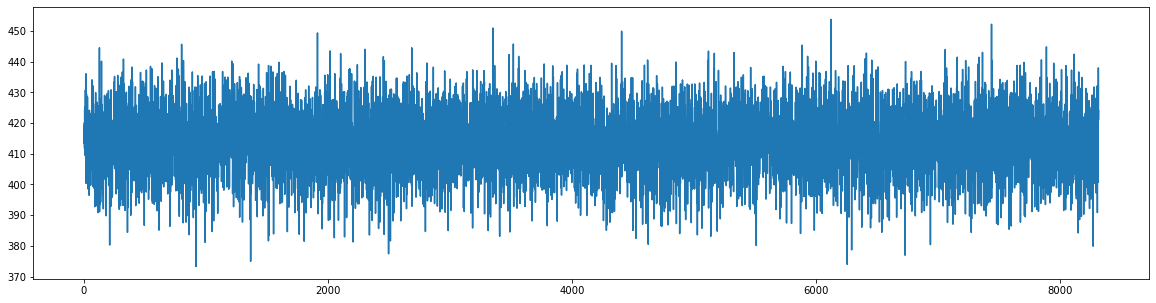

In [80]:
plt.figure(figsize=(20,5))
plt.plot(history_callback.history['loss'])

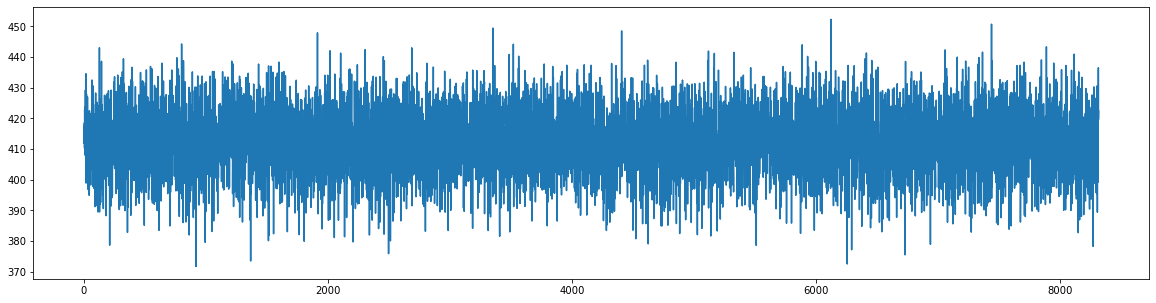

In [81]:
plt.figure(figsize=(20,5))
plt.plot(history_callback.history['reconstruction_loss'])

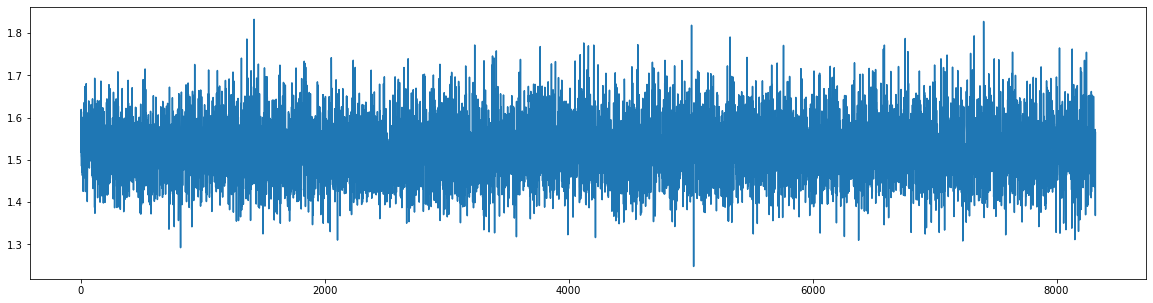

In [82]:
plt.figure(figsize=(20,5))
plt.plot(history_callback.history['kl_loss'])

predictions: 


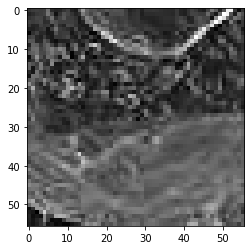

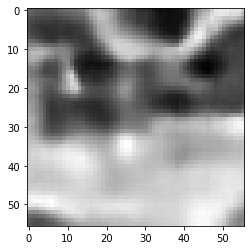

41.117950826883316

 next


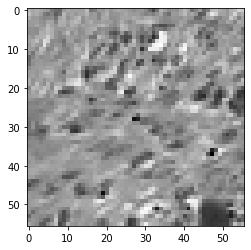

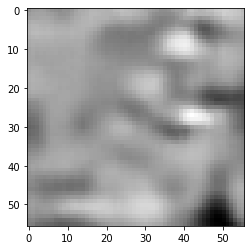

32.54487365484238

 next


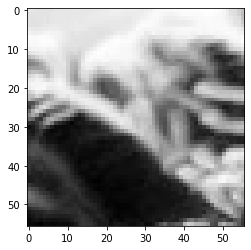

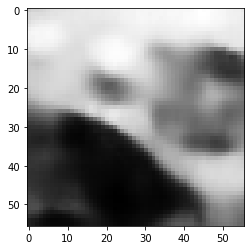

113.6780820786953

 next


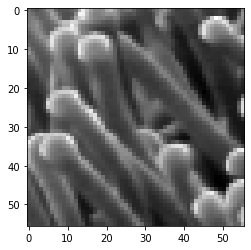

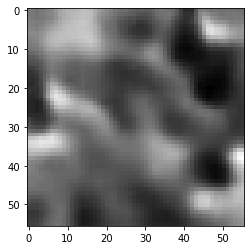

32.742839232087135

 next


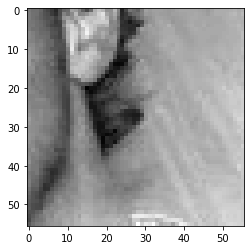

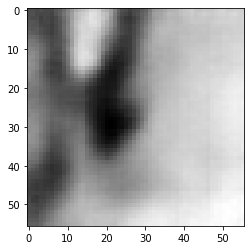

18.349963948130608

 next


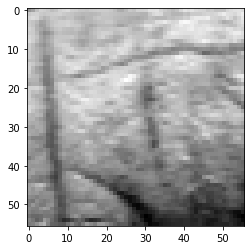

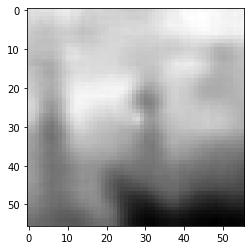

28.691717013716698

 next


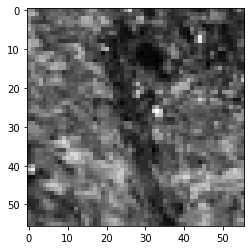

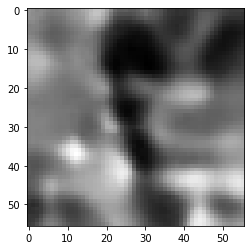

47.81986400485039

 next


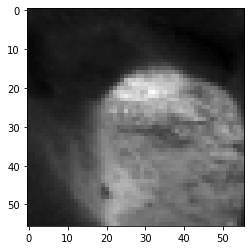

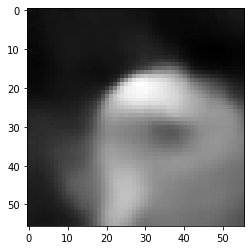

50.974055752158165

 next


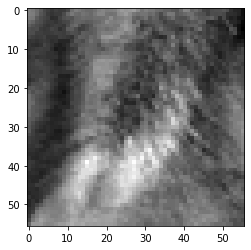

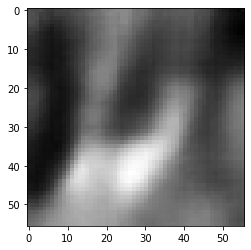

21.777121648192406

 next


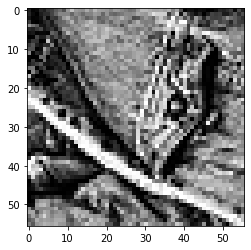

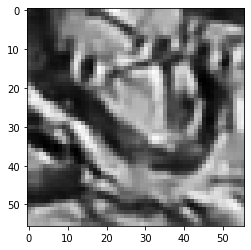

91.95372819900513

 next


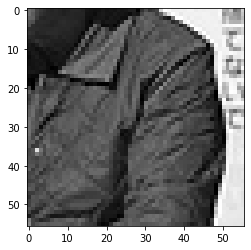

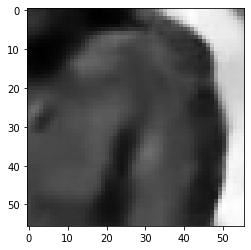

82.65076339244843

 next


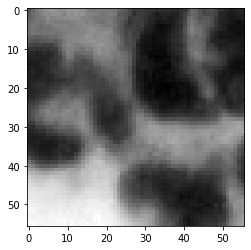

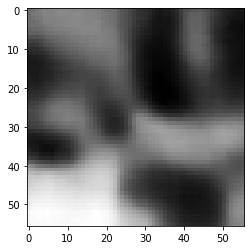

37.817858308553696

 next


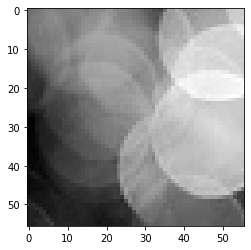

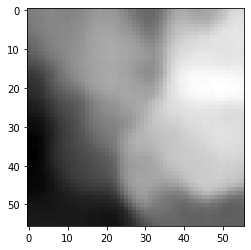

76.68281123042107

 next


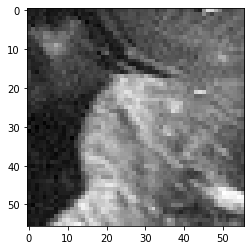

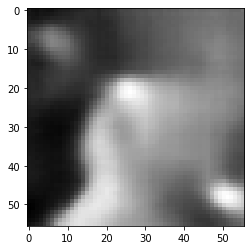

29.589899517595768

 next


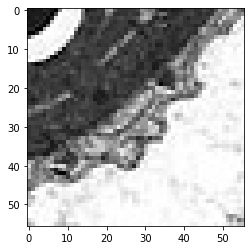

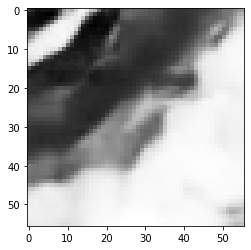

100.07092863321304

 next


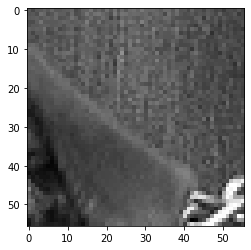

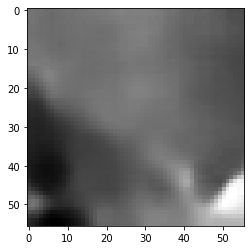

36.366096809506416

 next


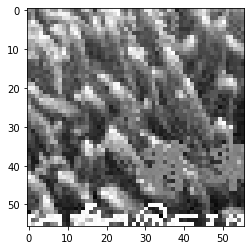

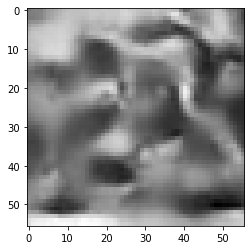

58.497237861156464

 next


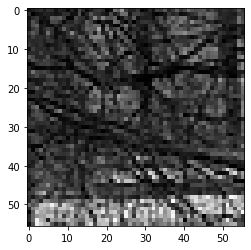

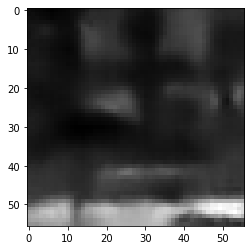

55.265963450074196

 next


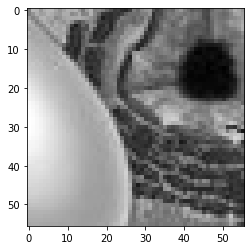

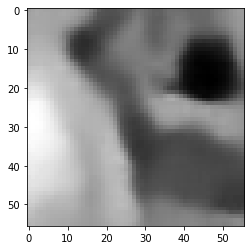

71.92555010318756

 next


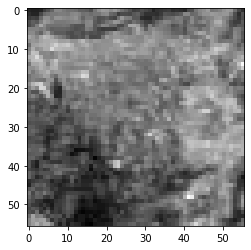

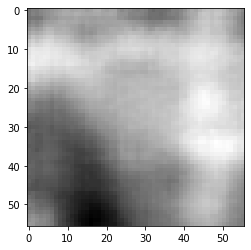

13.787409123033285

 next


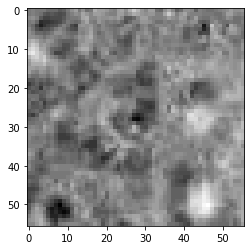

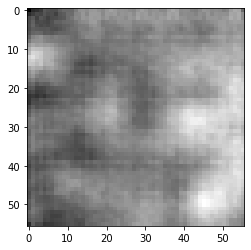

5.011115055531263

 next


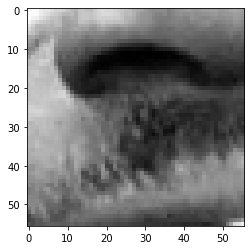

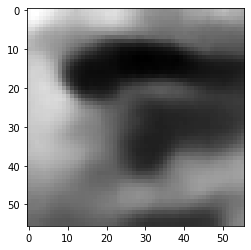

50.698304548859596

 next


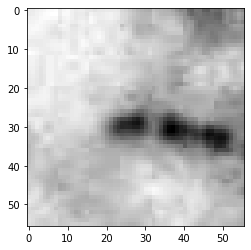

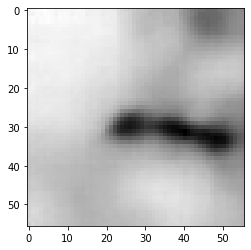

25.792339593172073

 next


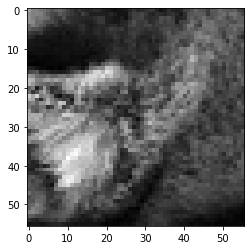

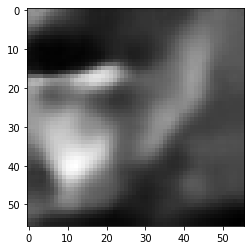

41.67720481753349

 next


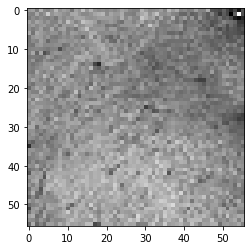

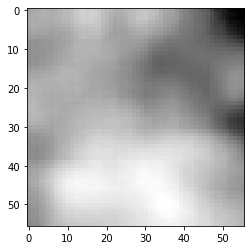

30.265602059662342

 next


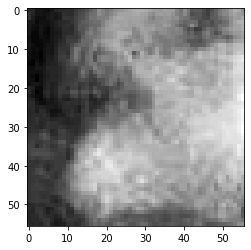

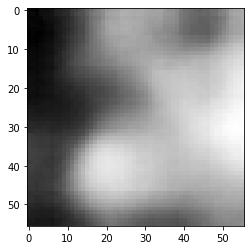

22.44027156382799

 next


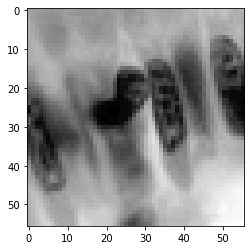

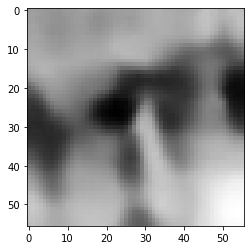

59.603909477591515

 next


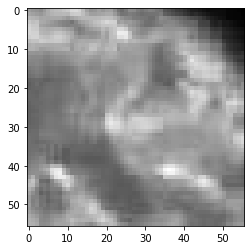

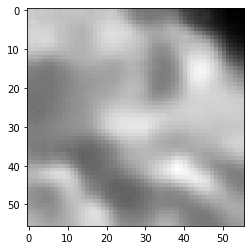

29.592812061309814

 next


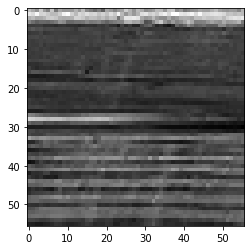

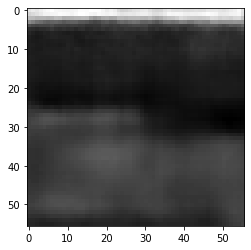

40.48190675675869

 next


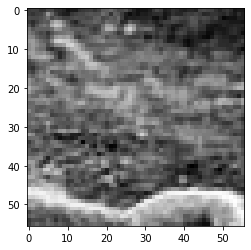

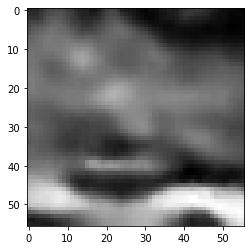

39.57346670329571

 next


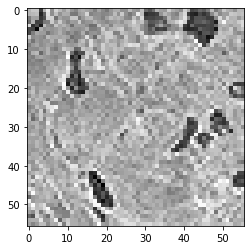

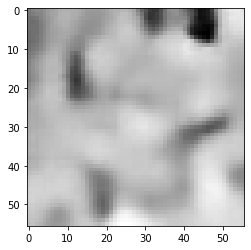

42.09189936518669

 next


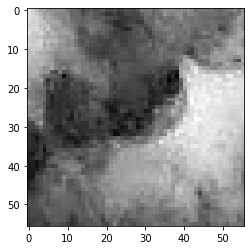

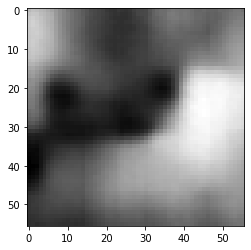

30.182517617940903

 next


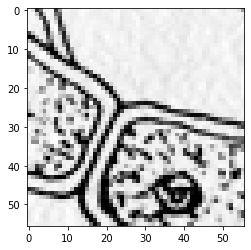

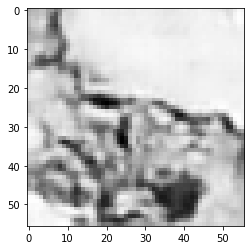

93.37108254432678

 next


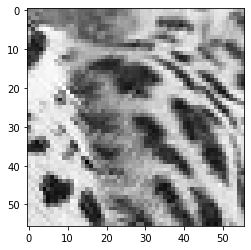

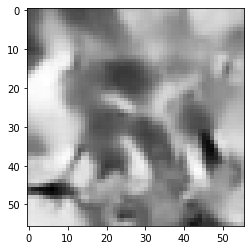

68.46229434013367

 next


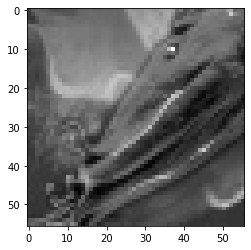

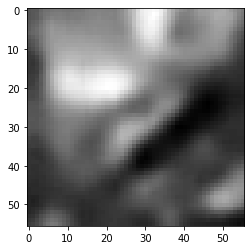

34.609177485108376

 next


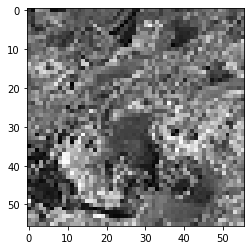

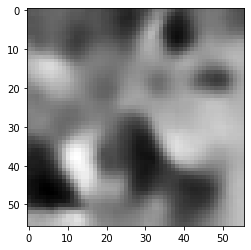

55.349570363759995

 next


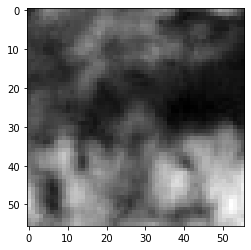

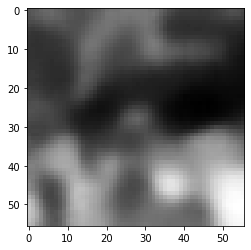

47.93551839888096

 next


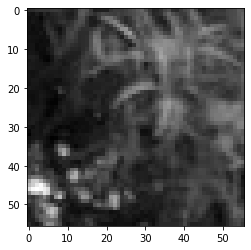

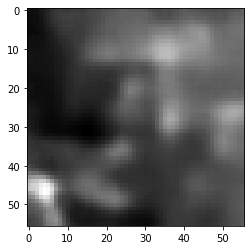

29.062653109431267

 next


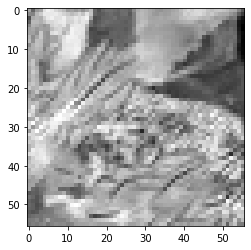

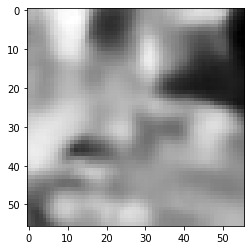

52.1609790623188

 next


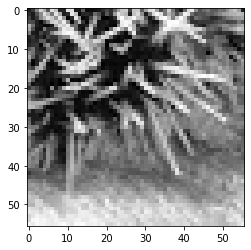

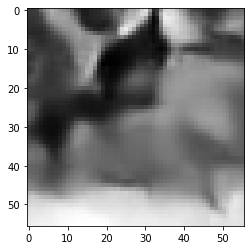

76.54405027627945

 next


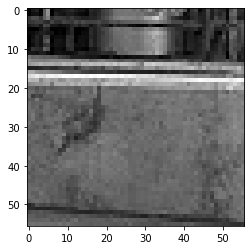

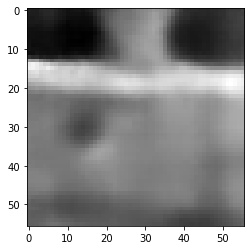

44.570859745144844

 next


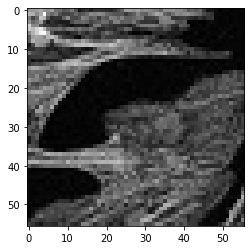

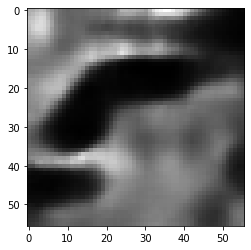

31.732030771672726

 next


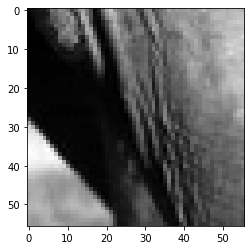

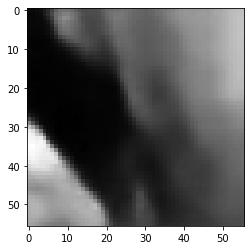

59.58141848444939

 next


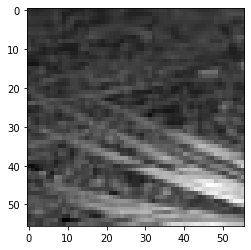

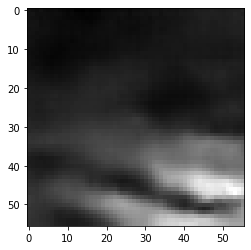

32.908339351415634

 next


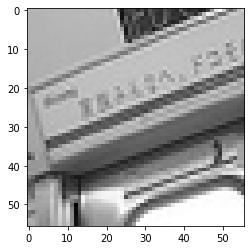

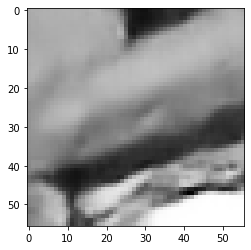

71.40702992677689

 next


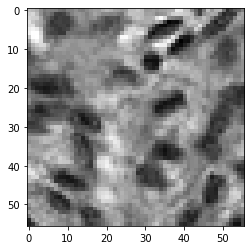

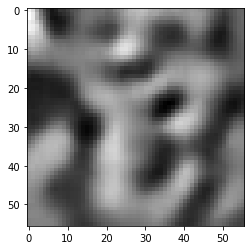

41.518403738737106

 next


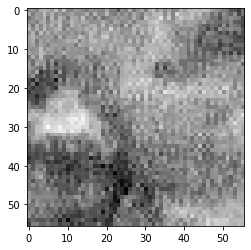

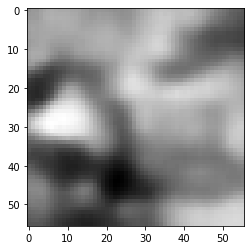

49.76766228675842

 next


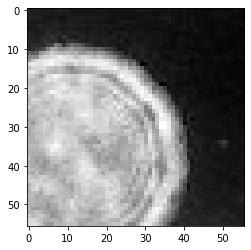

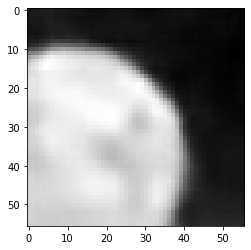

66.51782467961311

 next


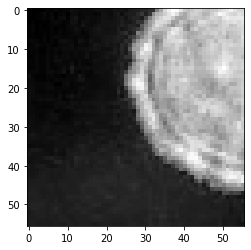

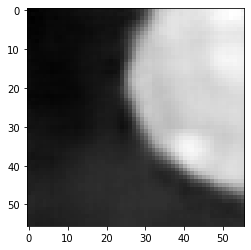

59.09062922000885

 next


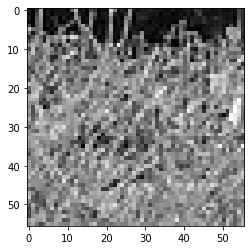

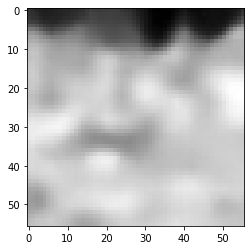

60.71055829524994

 next


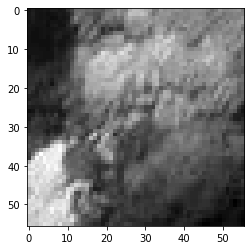

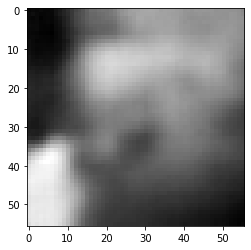

28.316823430359364

 next


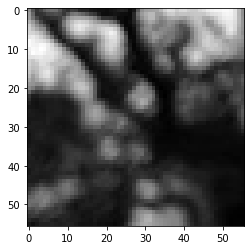

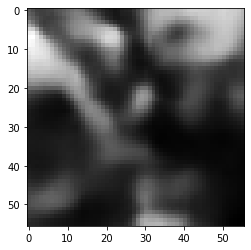

59.830620512366295

 next


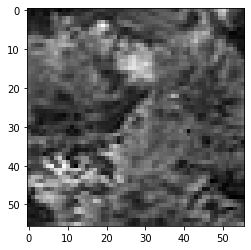

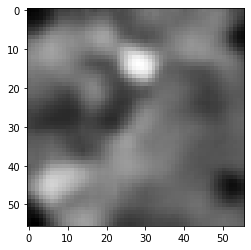

30.366697534918785

 next


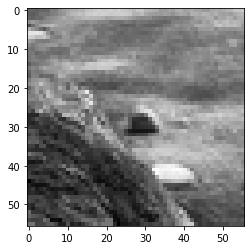

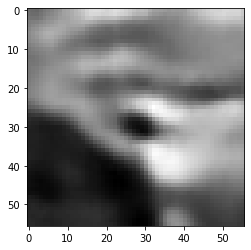

55.24113178253174

 next


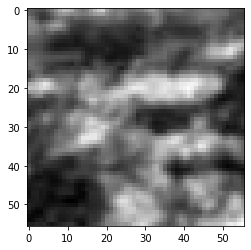

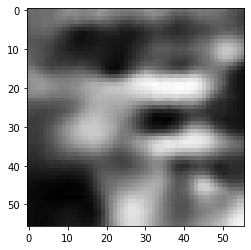

31.754453368484974

 next


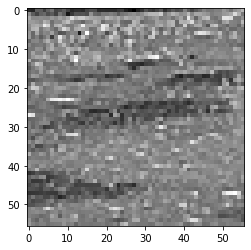

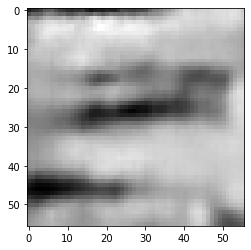

33.78484971821308

 next


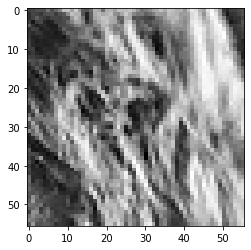

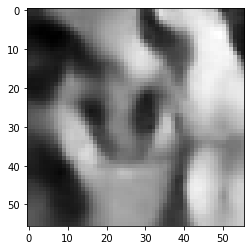

73.94301384687424

 next


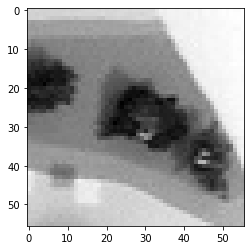

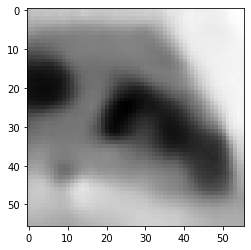

59.8494029045105

 next


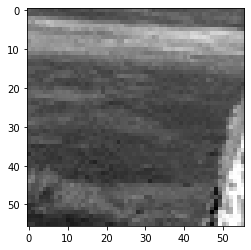

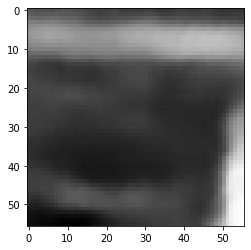

51.2022715061903

 next


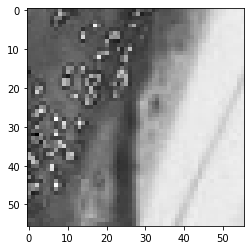

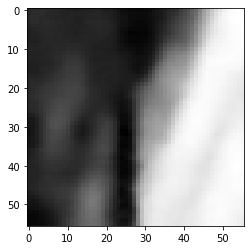

76.62459835410118

 next


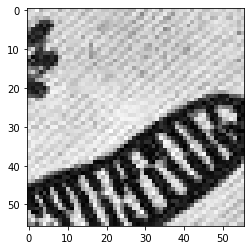

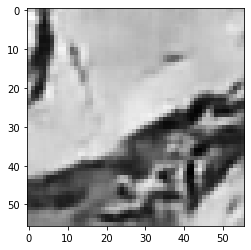

92.84246250987053

 next


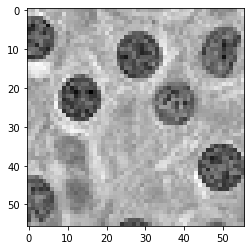

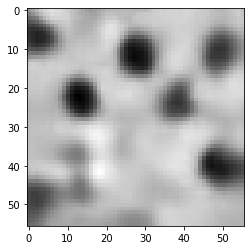

50.393188521265984

 next


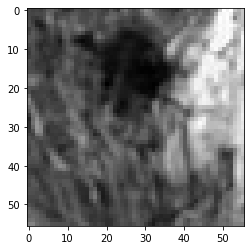

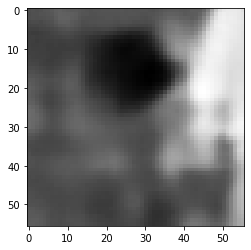

69.0784464776516

 next


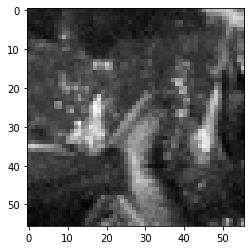

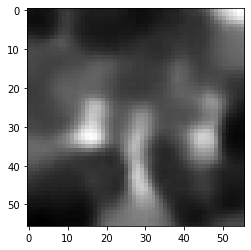

34.5076659321785

 next


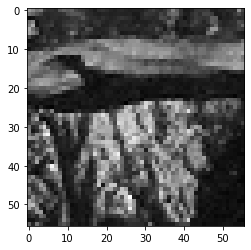

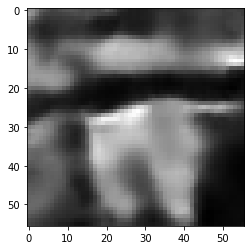

60.65900646150112

 next


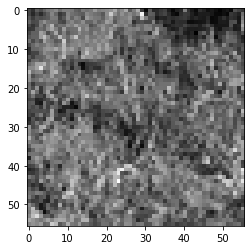

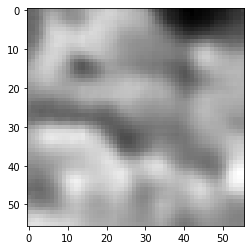

32.10083328187466

 next


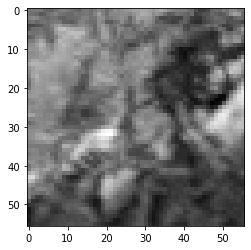

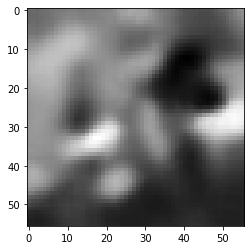

40.39433665573597

 next


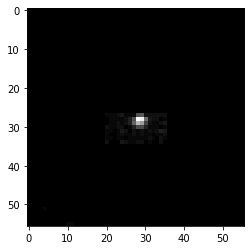

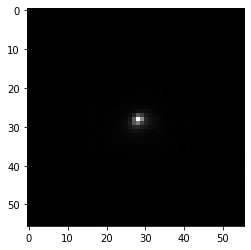

1.5111045772209764

 next


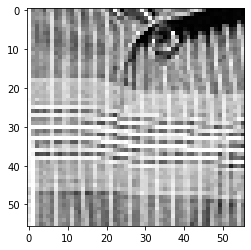

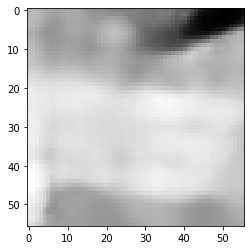

71.7325508594513

 next


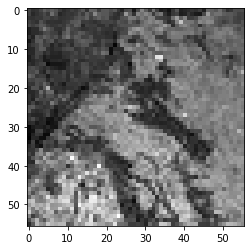

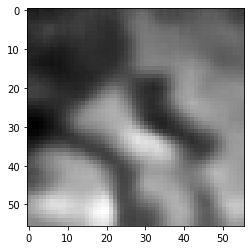

30.774206668138504

 next


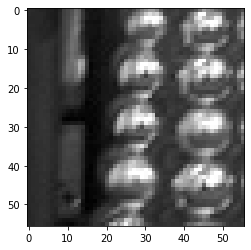

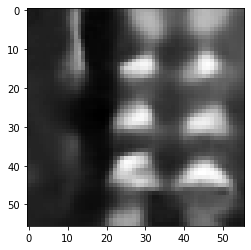

74.4377700984478

 next


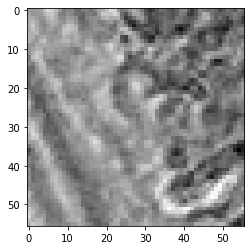

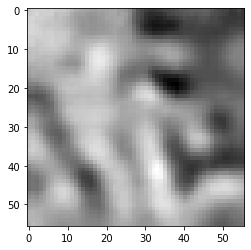

30.521288439631462

 next


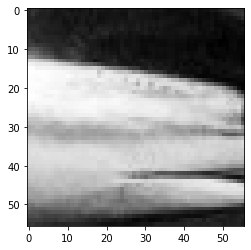

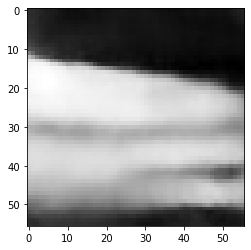

100.69313004612923

 next


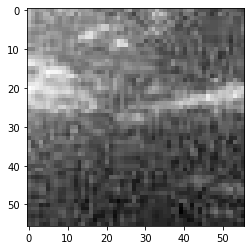

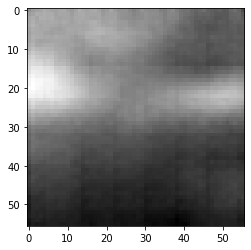

10.81750463694334

 next


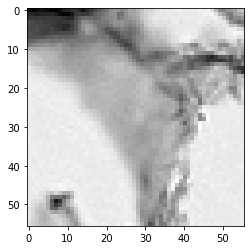

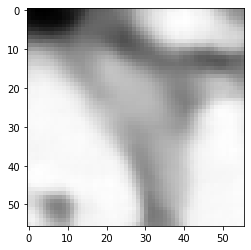

60.27754493057728

 next


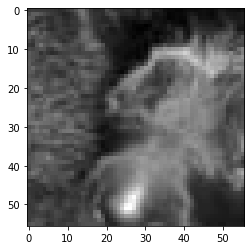

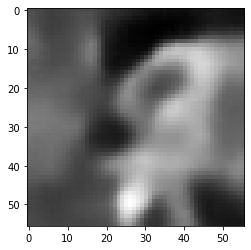

46.45188421010971

 next


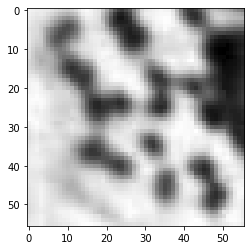

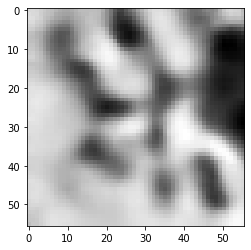

49.58817131817341

 next


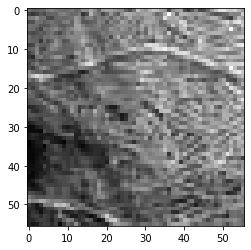

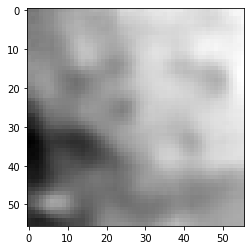

38.22985500097275

 next


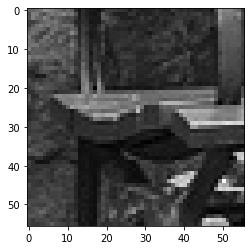

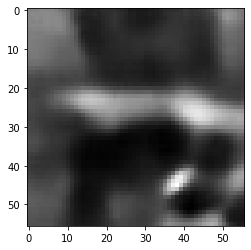

35.82305654883385

 next


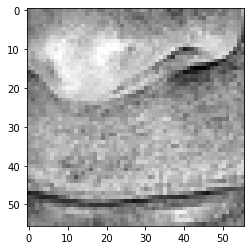

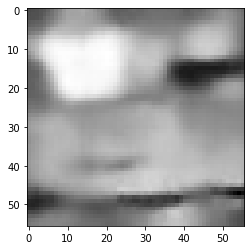

47.29028642177582

 next


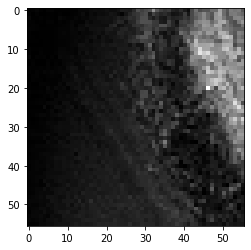

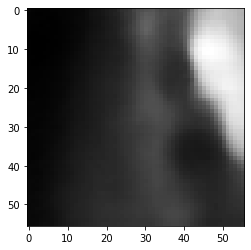

49.40408259630203

 next


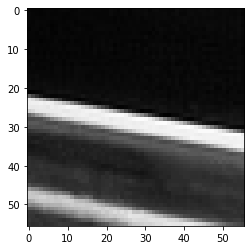

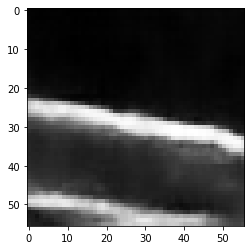

92.69063025712967

 next


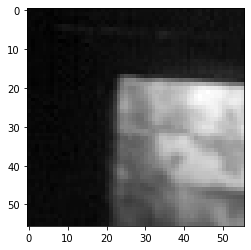

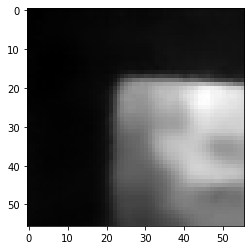

68.61164152622223

 next


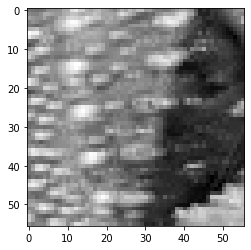

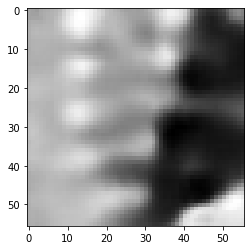

56.18926450610161

 next


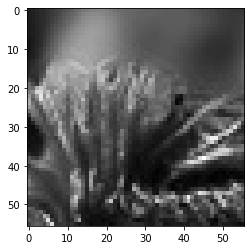

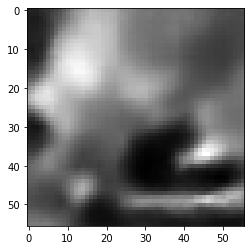

34.32627506554127

 next


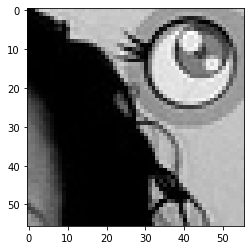

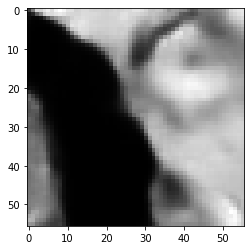

90.41000783443451

 next


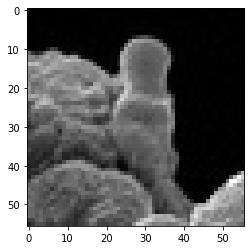

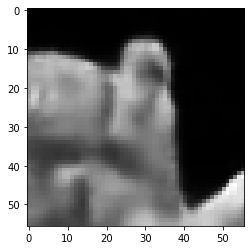

83.96920144557953

 next


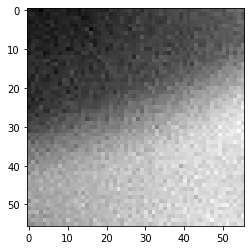

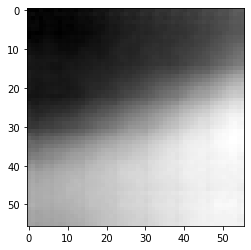

22.899750508368015

 next


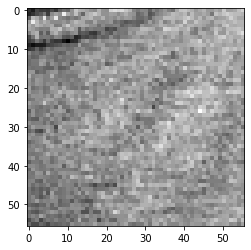

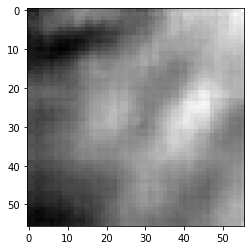

10.068483129143715

 next


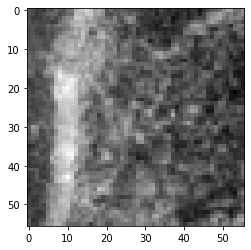

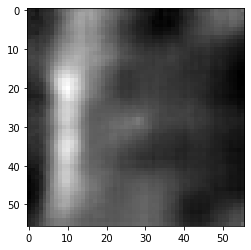

13.386320695281029

 next


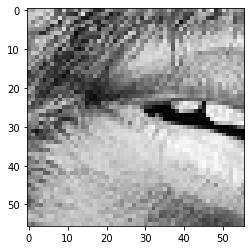

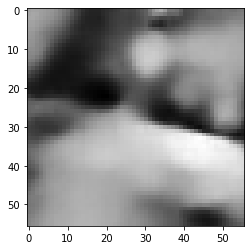

67.5326818227768

 next


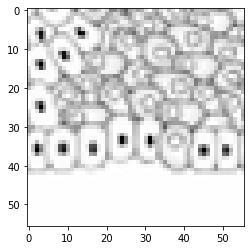

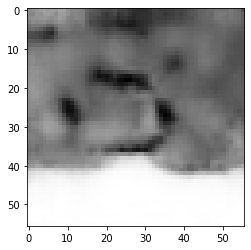

46.7361431568861

 next


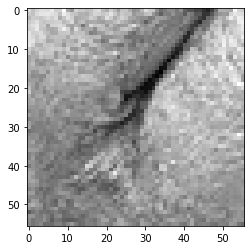

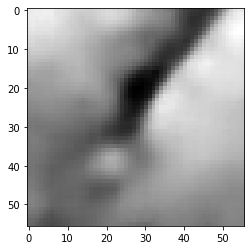

41.97826646268368

 next


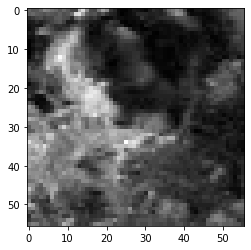

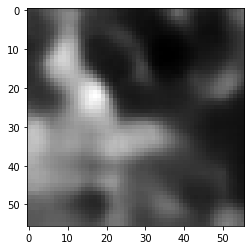

39.41957876086235

 next


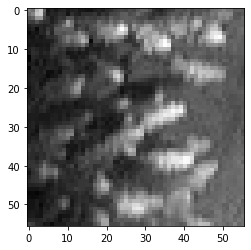

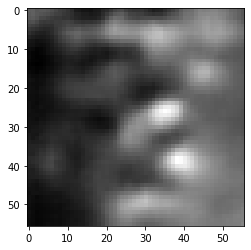

21.863831095397472

 next


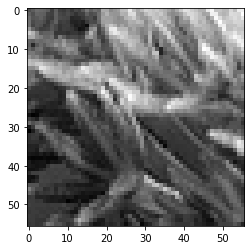

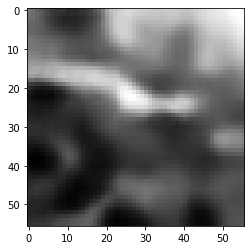

66.19208335876465

 next


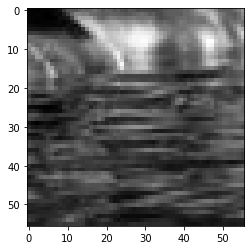

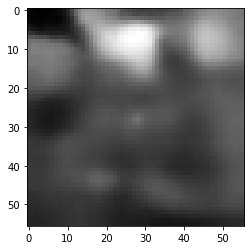

41.903437077999115

 next


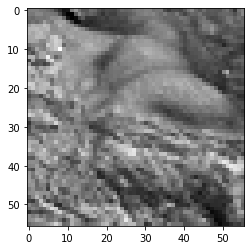

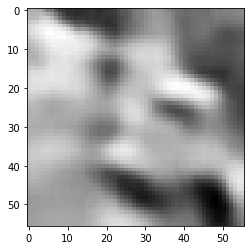

32.59464718401432

 next


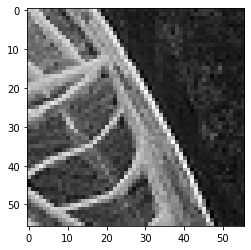

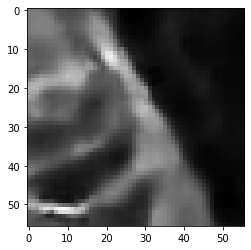

67.16221690177917

 next


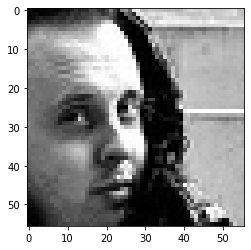

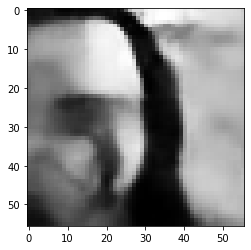

111.84620797634125

 next
0.1950289825256914


In [104]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], patch_size, patch_size, 1)
images = images / 255
predictions = decoder.predict_on_batch(encoder.predict_on_batch(np.array(images)))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape((patch_size, patch_size, 1))
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
#     ground_truth = im_1[5: 53, 5: 53, 0]
#     ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
#     plt.imshow(ground_truth[:, :], cmap='gray')
#     plt.show()
    
    
    pred_1 = predictions[i].reshape((patch_size, patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(im_1, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)